<a href="https://colab.research.google.com/github/btsp6/moving-sofa-problem/blob/main/MovingSofaProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# From https://stackoverflow.com/questions/63879856/saving-model-state-and-load-in-google-colab
from google.colab import drive
drive.mount('/content/gdrive')
title = "Moving Sofa Problem"
model_name = "moving_sofa"
PATH = f"/content/gdrive/My Drive/{title}/models/{model_name}"

Mounted at /content/gdrive


# Machine Learning Framework

Code copied/inspired from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
import os
import math
import random
from tqdm import tqdm
from collections import deque, namedtuple, OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import MultivariateNormal


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sofa Moving is non-Markovian while RL assumes Markovian
# However, policy gradients and actor critic methods said to still work well
# Here, we use PPO.
# Learn about it: https://stackoverflow.com/a/50663200/5045480
# Implementation: https://medium.com/analytics-vidhya/coding-ppo-from-scratch-with-pytorch-part-1-4-613dfc1b14c8


In [ ]:
class MLP(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.layers = nn.Sequential(OrderedDict([
      ("layer1", nn.Linear(in_channels, 64)),
      ("relu1", nn.ReLU()),
      ("layer2", nn.Linear(64, 64)),
      ("relu2", nn.ReLU()),
      ("layer3", nn.Linear(64, out_channels)),
    ]))

  def forward(self, x):
    return self.layers(x)

In [ ]:
eps = 1e-10

class PPO:
  def __init__(self, env, config, logger):
    self.env = env
    self.config = config
    self.logger = logger

    self.actor = MLP(env.state_dim, env.action_dim)
    self.critic = MLP(env.state_dim, 1)

    self.actor_optim = Adam(self.actor.parameters(), lr=config.adam_lr)
    self.critic_optim = Adam(self.critic.parameters(), lr=config.adam_lr)

    # Used to create Multivariate Normal distribution for action sampling
    # std set to 0.5 arbitrarily
    self.cov_mat = torch.diag(
      torch.full(size=(env.action_dim,), fill_value=config.sample_std))

  def learn(self, time_limit):
    timestep = 0
    counter = 0
    pbar = tqdm(total=time_limit)
    while timestep < time_limit:
      batch_states, batch_actions, batch_logprobs, batch_returns, batch_lengths = self.rollout()
      V, _ = self.evaluate(batch_states, batch_actions)
      A = batch_returns - V.detach()
      A = (A - A.mean())/(A.std() + eps)

      # Update actor and critic networks n times
      for _ in range(self.config.n_updates_per_iteration):
        curr_V, curr_logprobs = self.evaluate(batch_states, batch_actions)

        # Calculate actor loss
        prob_ratio = torch.exp(curr_logprobs - batch_logprobs)
        loss1 = prob_ratio * A
        loss2 = torch.clamp(prob_ratio, 1-self.config.loss_clip, 1+self.config.loss_clip) * A
        actor_loss = -torch.min(loss1, loss2).mean()

        self.actor_optim.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor_optim.step()

        # Calculate critic loss
        critic_loss = nn.MSELoss()(curr_V, batch_returns)

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

      delta_timestep = np.sum(batch_lengths)
      timestep += delta_timestep
      counter += 1
      pbar.update(delta_timestep)

      if counter % self.config.checkpoint_period == 0:
        torch.save(self.actor.state_dict, PATH + f"_actor_{counter}.pt")
        torch.save(self.critic.state_dict, PATH + f"_critic_{counter}.pt")
        # Print out interesting info about current sofa
        self.logger(self.env.sofa)

    pbar.close()


  def rollout(self):
    # Batch data
    batch_states = []
    batch_actions = []
    batch_logprobs = []
    batch_rewards = []
    batch_returns = []
    batch_lengths = []

    t = 0
    while t < self.config.timesteps_per_batch:
      # Start an episode of actor exploration
      ep_rewards = []

      state = self.env.reset()
      done = False

      for ep_t in range(self.config.max_timesteps_per_episode):
        last_ep = ep_t == self.config.max_timesteps_per_episode-1
        t += 1

        batch_states.append(state)

        action, logprob = self.get_action(torch.tensor(state))
        state, reward, done, _ = self.env.step(action)
        if last_ep:
          reward = self.env.finish()

        batch_actions.append(action)
        batch_logprobs.append(logprob)
        ep_rewards.append(reward)

        if done:
          break


      batch_rewards.append(ep_rewards)
      batch_lengths.append(ep_t+1)

    batch_states = torch.tensor(batch_states, dtype=torch.float)
    batch_actions = torch.tensor(batch_actions, dtype=torch.float)
    batch_logprobs = torch.tensor(batch_logprobs, dtype=torch.float)

    batch_returns = self.compute_returns(batch_rewards)

    return (
      batch_states, batch_actions, batch_logprobs, batch_returns, batch_lengths
    )


  def get_action(self, state):
    mean_action = self.actor(state)

    # Create distribution of actions
    action_dist = MultivariateNormal(mean_action, self.cov_mat)

    action = action_dist.sample()
    log_prob = action_dist.log_prob(action)

    return action.detach().numpy(), log_prob.detach()

  def compute_returns(self, batch_rewards):
    batch_returns = []

    for ep_rewards in reversed(batch_rewards):
      discounted_return = 0
      for reward in reversed(ep_rewards):
        discounted_return = reward + self.config.gamma * discounted_return
        batch_returns.append(discounted_return)

    batch_returns = list(reversed(batch_returns))

    return torch.tensor(batch_returns, dtype=torch.float)

  def evaluate(self, batch_states, batch_actions):
    V = self.critic(batch_states).squeeze()

    mean_actions = self.actor(batch_states)

    # Create distribution of actions
    action_dist = MultivariateNormal(mean_actions, self.cov_mat)

    log_probs = action_dist.log_prob(batch_actions)

    return V, log_probs


# Environment Instantiation

In [ ]:
%matplotlib inline
from typing import Tuple
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry.polygon import Point
from shapely import affinity

class SofaEnv:
  TRANSLATION_LIMIT = 0.1
  ROTATION_LIMIT = 1

  def __init__(self, hallway: Polygon, start_zone: Polygon, end_zone: Polygon):
    self.hallway = hallway
    self.start_zone = start_zone
    self.end_zone = end_zone

    self.sofa = Sofa(hallway, start_zone, end_zone)

    self.state_dim = 2
    self.action_dim = 3

  def reset(self):
    self.sofa = Sofa(self.hallway, self.start_zone, self.end_zone)

    return self.sofa.get_center()

  def step(self, action):
    # Dissect and clip action to valid ranges
    action = np.clip(action, -1, 1)
    x, y, rot = action
    x *= self.TRANSLATION_LIMIT
    y *= self.TRANSLATION_LIMIT
    rot *= self.ROTATION_LIMIT

    reward = -self.sofa.move((x, y), rot)

    done = False
    if self.sofa.is_degenerate():
      done = True
    if self.sofa.finished():
      done = True

    return self.sofa.get_center(), reward, done, None

  def finish(self):
    # Return the reward obtained at the final step
    return self.sofa.finish_area()


class Sofa:
  def __init__(self, hallway: Polygon, start_zone: Polygon, end_zone: Polygon):
    self.polygon = start_zone
    self.center = self.polygon.centroid

    self.hallway = hallway
    self.end_zone = end_zone

  def __str__(self) -> str:
    if self.polygon.is_empty:
      return "Polygon is empty."

    polygon_vertices = gpd.GeoSeries(self.polygon)
    hallway_vertices = gpd.GeoSeries(self.hallway)
    hallway_exterior = gpd.GeoSeries(self.hallway.buffer(0.1))
    f, ax = plt.subplots(figsize=(2,2))
    hallway_exterior.plot(ax=ax, color="k")
    hallway_vertices.plot(ax=ax, color="w")
    polygon_vertices.plot(ax=ax, color='b')
    plt.axis("off")
    plt.axis("square")
    plt.show()

    if type(self.polygon) == MultiPolygon:
      printstr = f"Disconnected Sofa with vertices at:"
      for poly in self.polygon.geoms:
        printstr += f"\n{list(poly.exterior.coords)}"
    else:
      printstr = f"Sofa with vertices at:\n{list(self.polygon.exterior.coords)}"

    return printstr

  def move(self, translation: Tuple, rotation: float):
    self.polygon = affinity.rotate(self.polygon, rotation, origin=self.center)
    self.polygon = affinity.translate(self.polygon, *translation)
    self.center = affinity.translate(self.center, *translation)

    cut_area = self.cut().area

    if self.is_degenerate():
      cut_area += self.polygon.area

    return cut_area

  def cut(self):
    polygon = self.polygon & self.hallway
    cuts = self.polygon - self.hallway

    self.polygon = polygon
    return cuts

  def is_degenerate(self):
    return self.polygon.is_empty or type(self.polygon) == MultiPolygon

  def finished(self):
    if self.polygon.intersects(self.end_zone):
      return self.polygon.covered_by(self.end_zone)
    return False

  def finish_area(self):
    if self.polygon.intersects(self.end_zone):
      return (self.polygon & self.end_zone).area
    return 0

  def get_center(self):
    return list(self.center.coords)[0]



### Example Sofa Code

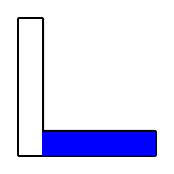

Sofa with vertices at:
[(0.0, 0.0), (5.0, 0.0), (5.0, -1.0), (0.0, -1.0), (0.0, 0.0)]


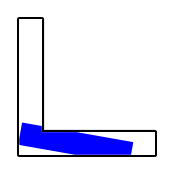

Sofa with vertices at:
[(0.0, 0.2722037770055699), (0.0, 0.0), (1.5437443317629618, 0.0), (4.048843471363985, -0.4417165676612218), (3.9504030393601295, -1.0), (1.4562556682370384, -1.0), (-1.0, -0.5668958541717101), (-1.0, -0.2812783411851911), (-0.8751952936970547, 0.4265243206734298), (0.0, 0.2722037770055699)]
0.7489890508905622


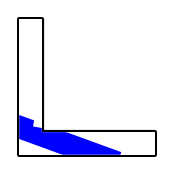

Sofa with vertices at:
[(-0.3903875406848468, 0.2528761430064995), (0.0, 0.18404028665133748), (0.0, 0.0), (1.043744331762962, 0.0), (1.1299038459039683, -0.015192246987791924), (3.520241623627605, -0.8852040479212174), (3.478459314056679, -1.0), (0.9562556682370378, -1.0), (0.8700961540960324, -0.9848077530122082), (-1.0, -0.3041484177055514), (-1.0, 0.7600293547703607), (-0.3431198508537741, 0.5209445330007909), (-0.3903875406848468, 0.2528761430064995)]
0.9877441400875088


In [ ]:
hallway = Polygon([
  [0, 0],
  [0, 5],
  [-1, 5],
  [-1, -1],
  [5, -1],
  [5, 0],
])
start_zone =  Polygon([(0, 0), (5,0), (5, -1), (0, -1)])
end_zone =  Polygon([(0, 0), (0,5), (-1, 5), (-1, 0)])
sofa = Sofa(hallway, start_zone, end_zone)
print(sofa)
translation = (-1, 0)
rotation = -10
loss = sofa.move(translation, rotation)
print(sofa)
print(loss)
translation = (-0.5, 0)
rotation = -10
loss = sofa.move(translation, rotation)
print(sofa)
print(loss)

# Training and Evaluation

  0%|          | 0/10000000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/shapely/predicates.py:639: RuntimeWarning: invalid value encountered in covered_by
  return lib.covered_by(a, b, **kwargs)
<ipython-input-4-6ea936e2b76e>:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  batch_actions = torch.tensor(batch_actions, dtype=torch.float)
  1%|          | 96567/10000000 [02:12<3:41:30, 745.13it/s]

Polygon is empty.


  2%|▏         | 150632/10000000 [03:26<3:37:24, 755.07it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
  2%|▏         | 197888/10000000 [04:30<3:40:42, 740.18it/s]

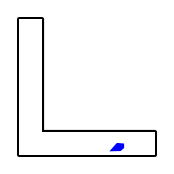

Sofa with vertices at:
[(3.64664233479495, -0.6763495501664393), (3.6466619552990593, -0.6999866394758437), (3.491750604586235, -0.835027032627991), (3.4865081972245817, -0.8357745553976915), (2.991726881984805, -0.8482827196384845), (3.3095083725591206, -0.4901537174999926), (3.313029089537364, -0.48727238933072425), (3.3481371685929813, -0.476516926215816), (3.6419905648395603, -0.5045027661239638), (3.64664233479495, -0.6763495501664393)]


/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
  3%|▎         | 296520/10000000 [06:46<3:47:31, 710.82it/s]/usr/local/lib/python3.10/dist-packages/shapely/predicates.py:639: RuntimeWarning: invalid value encountered in covered_by
  return lib.covered_by(a, b, **kwargs)
  3%|▎         | 302025/10000000 [06:53<3:39:28, 736.47it/s]

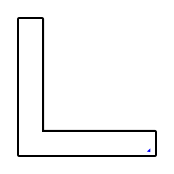

Sofa with vertices at:
[(4.649532185891059, -0.8607373355578104), (4.8050942824473815, -0.7172261706006067), (4.803083164211935, -0.882315981696366), (4.649532185891059, -0.8607373355578104)]


/usr/local/lib/python3.10/dist-packages/shapely/predicates.py:639: RuntimeWarning: invalid value encountered in covered_by
  return lib.covered_by(a, b, **kwargs)
/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
  4%|▍         | 407231/10000000 [09:18<3:46:52, 704.70it/s]

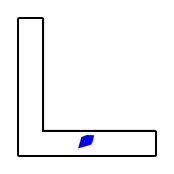

Sofa with vertices at:
[(2.1960642322538937, -0.5212550070601859), (2.1612051479012404, -0.5607248127232224), (1.603335537742541, -0.7191151665034264), (1.7503261749935073, -0.22070729988226523), (1.988512830865211, -0.12452258765410558), (2.317004405620676, -0.13830559951489846), (2.2369252924382743, -0.4548586097931874), (2.1960642322538937, -0.5212550070601859)]


/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
  5%|▌         | 512510/10000000 [11:45<3:41:11, 714.86it/s]

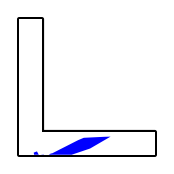

Disconnected Sofa with vertices at:
[(0.35434632484300455, -0.9715090583726923), (0.4233476776103101, -0.9321765964882299), (0.4326272520892739, -0.9504414334659125), (1.6025414291359463, -0.35605858990896505), (1.8564115955447933, -0.2498312257023111), (2.768875206281791, -0.20570009722572502), (3.043559233058302, -0.19749028755725412), (2.1425630753371485, -0.7209827131419215), (2.1083101708467558, -0.7337590829294172), (1.3219403340959814, -1.0), (0.30870899771834015, -1.0), (0.35434632484300455, -0.9715090583726923)]
[(-0.3469697474881198, -0.972779936686636), (-0.36026174302245717, -0.9066248034064682), (-0.21626426322761905, -0.8512244510301878), (-0.13613276746121666, -1.0), (-0.33903197052022704, -1.0), (-0.3469697474881198, -0.972779936686636)]
[(-0.010424151948706162, -0.9857904263132657), (-0.0027707814748255963, -1.0), (-0.03680625184153376, -1.0), (-0.010424151948706162, -0.9857904263132657)]
[(0.016360348425385057, -0.9952867002820092), (0.06380991650905773, -0.9730928487

/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
  6%|▌         | 617580/10000000 [14:15<3:45:34, 693.21it/s]

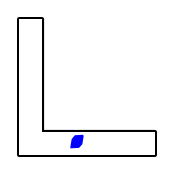

Sofa with vertices at:
[(1.847543259647778, -0.2017537059176668), (1.79636466437674, -0.5177036037294903), (1.7858438745660539, -0.5411561092682026), (1.6486241073359449, -0.6939436610745459), (1.6452954943190563, -0.6956239273838362), (1.2609468960633767, -0.7171134858208982), (1.266411071090671, -0.626016916774066), (1.321151859855811, -0.30534726417594027), (1.4612453816166242, -0.13606393929885602), (1.8386529290081022, -0.1149935084657557), (1.847543259647778, -0.2017537059176668)]


  6%|▋         | 628908/10000000 [14:31<3:44:20, 696.18it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
  7%|▋         | 727992/10000000 [16:51<3:39:10, 705.05it/s]

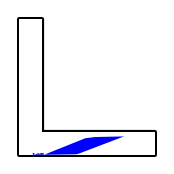

Disconnected Sofa with vertices at:
[(2.3564007187033633, -0.21614974843710924), (3.6421383278532624, -0.18784119076703681), (1.6336150334675712, -0.9526827497956117), (1.518707858945066, -0.9804504173676394), (0.31895057454888887, -1.0), (0.10067812244464203, -1.0), (1.9271577138791638, -0.26847075269781745), (2.3564007187033633, -0.21614974843710924)]
[(-0.40519825097482826, -0.9323394979669101), (-0.3692626758397654, -0.9183308246692922), (-0.3662874869959352, -0.925938059097387), (-0.3467223333941213, -0.9182861289151186), (-0.3186307780651287, -0.9921971087827846), (-0.13866989739842261, -0.9237988674747337), (-0.12412040451750408, -0.9623735717811832), (0.004063527891924393, -0.9140255352745964), (0.014212921169224305, -0.9380963148748286), (0.06507012268181443, -0.9166524834864537), (0.09845190603465992, -1.0), (-0.3960258589988684, -1.0), (-0.40519825097482826, -0.9323394979669101)]


/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
  8%|▊         | 834799/10000000 [19:24<3:46:31, 674.34it/s]

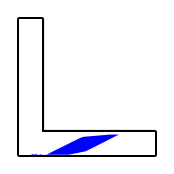

Disconnected Sofa with vertices at:
[(0.06066807262081412, -0.9988290974189928), (0.061261188362408146, -1.0), (0.058391817130298077, -1.0), (0.06066807262081412, -0.9988290974189928)]
[(0.11279771106220747, -0.9869027837476475), (0.11973385526851371, -1.0), (0.08856964205725128, -1.0), (0.11279771106220747, -0.9869027837476475)]
[(0.23518343904122246, -0.9784524794572546), (0.2388322693839914, -0.9852371880552997), (0.43604386000286793, -0.8791763859740929), (1.6539801622345365, -0.27720633324788463), (1.8236399503551366, -0.2091373501816286), (1.828084092521492, -0.20784088770336923), (2.9559839676322976, -0.11096109377955136), (3.4171084404568597, -0.10349829444481003), (2.1719343587306548, -0.7347057495364663), (1.9340164155425992, -0.8486174671555886), (1.206715129264654, -0.9958205605760804), (1.1642228438572468, -1.0), (0.1915874040337665, -1.0), (0.23518343904122246, -0.9784524794572546)]
[(-0.39706019122282615, -0.9574846365847275), (-0.38365527943636446, -0.9848224611301091),

  9%|▉         | 891276/10000000 [20:44<3:35:12, 705.40it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
  9%|▉         | 940319/10000000 [21:54<3:36:24, 697.75it/s]

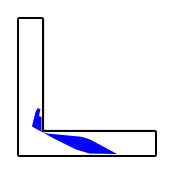

Disconnected Sofa with vertices at:
[(0.11825771351570406, -0.03896731484058222), (0.21169383290967006, -0.04257323444477665), (0.21055031257715814, -0.054263510414540694), (1.7505616915570523, -0.20490446437644438), (1.9676695744283295, -0.2657091157468477), (2.159404292659933, -0.336752556437363), (3.336261025592743, -0.9682530620562793), (2.1173168714996633, -0.9478846588763519), (1.524459619097971, -0.7674491626427384), (1.472298244930667, -0.7448028758948246), (0.6485985488937734, -0.3409317078981427), (0.018923923314735913, 0.0), (0.0844410647542291, 0.0), (0.08238127099079721, -0.028391712083942672), (0.11856454348147101, -0.03101677670831232), (0.11825771351570406, -0.03896731484058222)]
[(-0.437764683161773, 0.24726997128156528), (-0.27821331063854926, 0.8959052606059512), (-0.19003757870585833, 1.0670942085324353), (-0.05436124714389106, 1.0081892207228307), (-0.09344687768658005, 0.9204071389121649), (-0.07658331372319388, 0.9128985105325422), (-0.1181289283735321, 0.8193292

 10%|▉         | 960920/10000000 [22:25<3:49:59, 655.04it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 10%|█         | 1044399/10000000 [24:24<3:31:52, 704.46it/s]

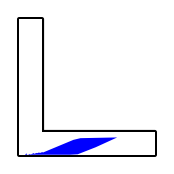

Disconnected Sofa with vertices at:
[(-0.350810681986675, -0.9266023989422848), (-0.33668513631834307, -0.9602293999646198), (-0.27218761925113494, -0.9331362130871533), (-0.27103976048644646, -0.9358637361908843), (-0.22624150879692004, -0.9170107095110328), (-0.2185985214547904, -0.9364240141653103), (-0.15737705263410884, -0.9123212187064257), (-0.15692673651527586, -0.9134721441245929), (-0.12970978899645974, -0.9028231220596424), (-0.1227186011553085, -0.9196455809841336), (-0.08144824618082458, -0.9024941761156352), (-0.07285646033495555, -0.9215441732675033), (0.027777339601781623, -0.8761570768275636), (0.040205552651293816, -0.9060203870680744), (1.3973924362426646, -0.3411999568668884), (1.7097045605722814, -0.2660977654461588), (3.3358447077531497, -0.23387304549694785), (2.3852430737610173, -0.6678948135600796), (1.5867455943084416, -0.9803778677220544), (1.2389646871733684, -1.0), (-0.6216515235034983, -1.0), (-0.528157841025401, -0.9627796531121905), (-0.5229672854611727,

 11%|█         | 1050028/10000000 [24:32<3:38:13, 683.56it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 11%|█▏        | 1149406/10000000 [26:58<3:36:39, 680.82it/s]

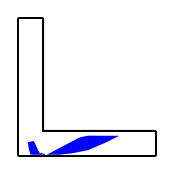

Disconnected Sofa with vertices at:
[(1.3571305816108459, -0.9338314189055508), (0.7817759562932973, -1.0), (0.21417001063621377, -1.0), (1.649196959569268, -0.24605370383277686), (1.8317822712390097, -0.19729495226333624), (2.071437371356518, -0.15538549885912867), (3.429287397202004, -0.16153722744560983), (2.841729874954025, -0.4561527857397762), (2.0409348292909684, -0.7965058547283074), (1.3571305816108459, -0.9338314189055508)]
[(-0.5704280997116461, -0.7822435857951605), (-0.635257571805685, -0.39314501130398577), (-0.6345516894269757, -0.3930102335837216), (-0.6252221876513576, -0.4424190119117632), (-0.3569015822009871, -0.3917539752584649), (-0.2951585771133297, -0.5181345964332558), (-0.15535525216143736, -0.8318385850719527), (-0.14430500324531553, -0.8269140014008196), (-0.08461290933632219, -0.9490966502163759), (-0.0051429380657721895, -0.9102717513128694), (0.0027514689843746234, -0.9270824711408642), (0.010735157643896376, -0.9233332867701299), (0.02461015056636253, -0

 12%|█▏        | 1170905/10000000 [27:29<3:34:39, 685.53it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 13%|█▎        | 1254264/10000000 [29:31<3:36:31, 673.21it/s]

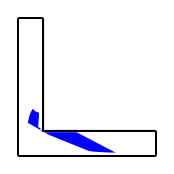

Disconnected Sofa with vertices at:
[(3.223598161902875, -0.8832085377008838), (3.2682540278273016, -0.9096000232574868), (2.870523626356498, -0.8980249641049728), (2.3037619948697072, -0.8640173426003076), (2.082570565900571, -0.8325610558832314), (0.3001434922254128, -0.1135775017473469), (0.10264599129755878, 0.0), (1.3724271590122417, 0.0), (1.5186288964589392, -0.005394765873106826), (1.5637525195704658, -0.01665758044131912), (3.223598161902875, -0.8832085377008838)]
[(-0.6227551976053622, 0.4171660624214474), (-0.5374652156970298, 0.7700382730458134), (-0.4238652830236782, 1.0215921222257873), (-0.31324076968459447, 0.9779551898833164), (-0.32826371162404655, 0.9380123264296344), (-0.14850549422670067, 0.8704033212257116), (-0.14867723461828714, 0.869991856816829), (-0.13774985220839817, 0.865430896273009), (-0.14318241524214934, 0.8523533999655615), (-0.12187279018768393, 0.8435011029652508), (-0.140213457356521, 0.48829358443461646), (-0.15595153462017178, 0.3806626013164238),

 13%|█▎        | 1265597/10000000 [29:48<3:33:46, 680.94it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 14%|█▎        | 1360234/10000000 [32:04<3:32:00, 679.20it/s]

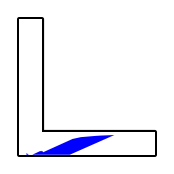

Disconnected Sofa with vertices at:
[(-0.655021305354989, -0.9352645765412916), (-0.6415508289846295, -0.9663810016537918), (-0.6221393017692174, -0.9579776417651661), (-0.6123724861426246, -0.9792050310078325), (-0.6004450343917924, -0.9737171577317693), (-0.5881588334202192, -1.0), (-0.6804708177907601, -1.0), (-0.6907205932342836, -0.9505940144296655), (-0.655021305354989, -0.9352645765412916)]
[(-0.07749036555034539, -0.8382741135089348), (-0.07262522752637018, -0.8489552117890712), (-0.02827369574916759, -0.8287535136105125), (-0.026993223290695603, -0.8315723350186853), (-0.014849387101552966, -0.8260558990588541), (-0.000645691852609584, -0.8570062080133446), (0.03509893522842146, -0.840602307470948), (0.05718250566186374, -0.8894527533113837), (1.3581247749097065, -0.30134245588198666), (1.7251653663369668, -0.22137419397557861), (2.4101578685028757, -0.1630931805061098), (2.597174014775851, -0.15186697044169822), (3.2098274649377774, -0.1268801822467808), (1.2351377475956267, 

/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 15%|█▍        | 1470403/10000000 [34:44<3:21:21, 705.98it/s]

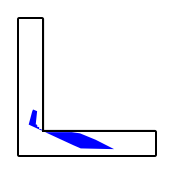

Disconnected Sofa with vertices at:
[(-0.01894880044313803, 0.11023415330470032), (-0.0004107406285805248, 0.10923068119520093), (-0.0002972224610016353, 0.09004781636026563), (0.0, 0.09004957522941404), (0.0, 0.06670785111103322), (-0.5821812507502245, 0.33546981540035703), (-0.4283923370114982, 0.9141632689225514), (-0.38956904730106445, 1.004135204733588), (-0.209337467241903, 0.9295507186597535), (-0.2707345713161522, 0.34221806143926936), (-0.21989509222764925, 0.3369035318446624), (-0.22372461543759195, 0.3046769885810575), (-0.19918664035391323, 0.30176110820445945), (-0.20465114959416875, 0.23372314349372664), (-0.1362543667251115, 0.2282298155615822), (-0.13643691942831115, 0.22408555022746626), (-0.13004024433866057, 0.22380378006195792), (-0.1310326892013152, 0.21390021116775088), (-0.11730281045848805, 0.2125243286178608), (-0.12116304121521007, 0.1401335608763293), (-0.017629184498650773, 0.13461262788268782), (-0.01894880044313803, 0.11023415330470032)]
[(1.69070834645763

/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 16%|█▌        | 1577867/10000000 [37:17<3:20:11, 701.18it/s]

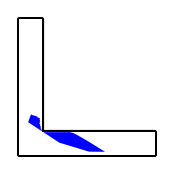

Disconnected Sofa with vertices at:
[(-0.04983090435972071, 0.2669767460068655), (-0.05517855451529266, 0.15561712815717504), (-0.029655911720361694, 0.1543914938801506), (-0.03182511538025297, 0.10580647563147558), (0.0, 0.10438556113462469), (0.0, 0.04332745702582702), (-0.6059250639638759, 0.4404138330885014), (-0.47574351427321804, 0.8013134712494655), (-0.46307888232478556, 0.7971013815880261), (-0.47041461917878136, 0.7726695558029872), (-0.22605282284565106, 0.699299114688959), (-0.19168347202436345, 0.6883371853463146), (-0.20224961526230414, 0.6592136190598502), (-0.08224729802452196, 0.615676311150948), (-0.10440718917433173, 0.5452837490468034), (-0.08115965931764385, 0.5379653234102431), (-0.08780462588768709, 0.5081611370581705), (-0.08175074958068618, 0.5068114003062928), (-0.10605800680003916, 0.35865765737720495), (-0.07440339938438517, 0.3534641558873492), (-0.07573072771954098, 0.3427675126669604), (-0.07058541309415389, 0.34212903929219657), (-0.0819025647380299, 0.2

 16%|█▌        | 1583124/10000000 [37:25<3:22:54, 691.34it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 17%|█▋        | 1686423/10000000 [39:52<3:15:18, 709.44it/s]

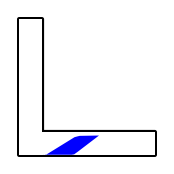

Disconnected Sofa with vertices at:
[(1.3227622760640483, -1.0), (0.14614372475269552, -1.0), (0.1721530102567301, -0.9825466437318617), (0.17410183024781398, -0.9857104105873982), (0.1869179680724447, -0.9778159143297429), (0.19698789113740237, -0.9941288977614993), (1.4463577073304874, -0.22289916033327875), (1.595435649407911, -0.18258140922290345), (1.679397142935194, -0.16381045270119418), (2.5311403004532194, -0.14923927898045602), (1.6247871082356522, -0.8409710005815274), (1.4308820121654175, -0.982303520910011), (1.3227622760640483, -1.0)]
[(0.06558107417406998, -0.9897241919940387), (0.07187008560751247, -1.0), (0.05026159645512644, -1.0), (0.06558107417406998, -0.9897241919940387)]
[(0.11966616367835672, -0.9939298802629001), (0.12373947673977961, -1.0), (0.10974800950551648, -1.0), (0.11966616367835672, -0.9939298802629001)]


/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 18%|█▊        | 1795292/10000000 [42:26<3:18:30, 688.88it/s]

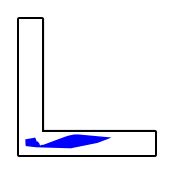

Sofa with vertices at:
[(-0.22453578176993128, -0.41899566525085463), (-0.21487334189033583, -0.41536079070531323), (-0.21464124839944604, -0.4161700646709171), (-0.18134251461653084, -0.4066202463221351), (-0.17396929910095155, -0.4283433318172271), (-0.1725687971371687, -0.42786797564320234), (-0.16827389942636928, -0.4425879241265264), (-0.14911208937166504, -0.4369970068599382), (-0.13305587416630385, -0.48716216002097096), (-0.11874850495837372, -0.482582841818002), (-0.07972608974031974, -0.5913768632140539), (0.02432943998126358, -0.5540540578390387), (0.030195997603755895, -0.5700314475187278), (0.0487038918981032, -0.5632357424301275), (0.04972377300746554, -0.5659759165543918), (0.6705432786439103, -0.3349095472621526), (0.9749282543211087, -0.22314585901079664), (1.1546287673591542, -0.16084364341350693), (1.40773521699171, -0.10572003266862563), (1.4936172760242716, -0.10040147775482079), (1.617169301570978, -0.10087413344629083), (3.086794320124907, -0.2372616752273362), (

 19%|█▊        | 1859085/10000000 [43:57<3:13:24, 701.50it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 19%|█▉        | 1902097/10000000 [44:58<3:14:11, 694.99it/s]

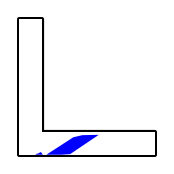

Disconnected Sofa with vertices at:
[(-0.20186624251820168, -0.9410159074254765), (-0.19259490862682016, -0.9580959564951087), (-0.08428289812933043, -0.8993024009452927), (-0.08269021915076549, -0.9021978747627474), (-0.03993604364482653, -0.8786805919734156), (0.0008426735483652859, -0.939988964917622), (0.0037770043485053084, -0.9380372209697095), (0.04392249824603514, -1.0), (-0.2928193992389267, -1.0), (-0.20186624251820168, -0.9410159074254765)]
[(0.13229503786103392, -0.9841748613102845), (0.1425480582093378, -1.0), (0.10885533675515612, -1.0), (0.13229503786103392, -0.9841748613102845)]
[(1.395880389179063, -0.22497746069395191), (1.7958996537989285, -0.1324066108657178), (2.5197667943755757, -0.11861949270204424), (1.2528467170979907, -0.9731048361423725), (0.8490567755359015, -1.0), (0.1996632009236443, -1.0), (1.395880389179063, -0.22497746069395191)]


 19%|█▉        | 1912370/10000000 [45:13<3:14:56, 691.46it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 20%|██        | 2005661/10000000 [47:25<3:02:52, 728.60it/s]

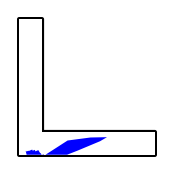

Disconnected Sofa with vertices at:
[(-0.4266606216792771, -0.7714763508839042), (-0.403641190553907, -0.8230663798392774), (-0.3139696517290889, -0.7830550083847392), (-0.2830223021531898, -0.851339145449755), (-0.15772377459305506, -0.7945520569630586), (-0.06767350607286088, -0.937550226189382), (-0.05089137831085285, -0.9269820131871771), (-0.008044654815327883, -1.0), (-0.6740977070674589, -1.0), (-0.7143731980554137, -0.8340225234551837), (-0.6973807305094948, -0.8270191798691997), (-0.6836340553770544, -0.8588486069461612), (-0.5919813005583904, -0.8192650906472649), (-0.5838955189183276, -0.837963692752159), (-0.47385867552174976, -0.7903807834482812), (-0.47353201285155355, -0.7911586955348562), (-0.4266606216792771, -0.7714763508839042)]
[(0.06850164357465177, -0.9677794646863922), (0.08924318179752694, -1.0), (0.0135924596115721, -1.0), (0.06850164357465177, -0.9677794646863922)]
[(1.1412867396650626, -0.36941724569894174), (2.152611164999795, -0.23639924092108172), (2.88478

/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 21%|██        | 2114367/10000000 [50:00<3:07:07, 702.34it/s]

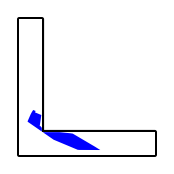

Disconnected Sofa with vertices at:
[(1.6664404673763153, -0.7869282633993532), (1.5882320529589184, -0.7808206427938024), (0.5224917408433872, -0.33454648723460945), (0.03917613572829659, 0.0), (0.7755821355335673, 0.0), (1.2807655897673618, -0.05047492225978947), (1.3685302771165997, -0.06477505873071018), (2.353203823448535, -0.6441780822152393), (2.5876355422884063, -0.7910187638691016), (1.6664404673763153, -0.7869282633993532)]
[(-0.6299608003161872, 0.46317025368817755), (-0.6262018058790539, 0.49099042089554323), (-0.4937673046706154, 0.794194646864332), (-0.4409011066667971, 0.8916575516358419), (-0.38321037930476315, 0.981624483375578), (-0.27652730468012754, 0.9390239719095169), (-0.30267376701028925, 0.875952895681326), (-0.02233181231487215, 0.7597355929752739), (-0.09355105232016724, 0.2686102043497941), (-0.0672376135104485, 0.2647944311127417), (-0.06778806539602548, 0.2609874588385116), (-0.03741673253356162, 0.25659605374349703), (-0.04157029366065068, 0.2304191174200

 22%|██▏       | 2182955/10000000 [51:37<3:01:26, 718.03it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 22%|██▏       | 2220224/10000000 [52:29<2:59:42, 721.50it/s]

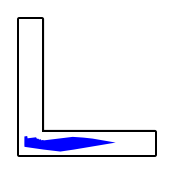

Sofa with vertices at:
[(-0.7671899282392164, -0.6497262765751748), (-0.7682087456991017, -0.6429427674757605), (-0.7738253874723049, -0.5681507586448915), (-0.7720615743900942, -0.19030655182592726), (-0.6504793933455788, -0.17094241998607695), (-0.6479893251192645, -0.1898813206073558), (-0.642792467531287, -0.1891980428281808), (-0.6325965694198443, -0.2722964910110988), (-0.24798884821266765, -0.22510642640640888), (-0.2453336068425725, -0.26613592341731906), (-0.23014502560923988, -0.26515298791525777), (-0.22854931169582193, -0.2809571677205509), (-0.20467264730177354, -0.27854639246685153), (-0.20166445096826996, -0.29734487177333724), (-0.17249376172122255, -0.29267687927202024), (-0.17208995623913081, -0.2968978267047786), (-0.13496484021143812, -0.29334617731466067), (-0.13086850049249513, -0.3282554710888983), (-0.03803982478420977, -0.31736273307420254), (-0.03170918682246459, -0.3594740088790417), (0.07175332034617507, -0.34392036765158046), (0.07438691254219004, -0.365582

 23%|██▎       | 2296438/10000000 [54:17<2:59:29, 715.34it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 23%|██▎       | 2330634/10000000 [55:04<2:53:42, 735.85it/s]

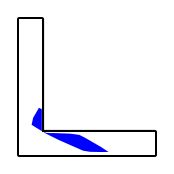

Disconnected Sofa with vertices at:
[(0.16319530458836565, -0.028115235734652494), (0.333367852820481, -0.03400341284469566), (0.33350767577674, -0.042350617094277315), (0.4959619477714726, -0.039629366255305304), (1.2669115144650485, -0.06630515878919177), (1.63860729702054, -0.11790227202991779), (1.6677353956850147, -0.12404837233580948), (1.8973752280682703, -0.24045807190551197), (2.138437462902366, -0.3773971204521023), (2.589396021168058, -0.6374505946337017), (2.9540344445049387, -0.8749602724225386), (2.631512894443855, -0.8798981896310452), (2.1349053772199045, -0.8699934970300233), (1.8280928465123456, -0.8209619489390401), (0.7579886248328672, -0.3500134084103146), (0.16980667557143087, -0.05849493541057449), (0.07446723007933774, 0.0), (0.16416812593479368, 0.0), (0.16319530458836565, -0.028115235734652494)]
[(-0.35170498028635677, 0.26147536091124546), (-0.45287894285891694, 0.32795336192087754), (-0.38691859209807816, 0.6319629998917097), (-0.12840640359719685, 1.0774073

 23%|██▎       | 2342730/10000000 [55:21<3:00:28, 707.14it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 24%|██▍       | 2437930/10000000 [57:36<2:57:59, 708.12it/s]

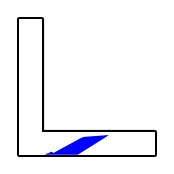

Disconnected Sofa with vertices at:
[(0.07858567645184299, -1.0), (0.05955130327648558, -1.0), (0.07340772803260537, -0.9907508627543773), (0.07858567645184299, -1.0)]
[(0.2591848450498425, -0.9281171532694518), (0.26787616346527365, -0.9444530564742528), (0.42687679125466305, -0.8598587082434817), (0.4401086833271701, -0.8840957273139737), (0.45876761807532007, -0.8739091193793335), (0.4643248404684034, -0.8835175445559241), (0.47272720520116496, -0.8786578710309098), (0.49986473847091895, -0.9285922915400538), (1.7640278870478698, -0.24156580453752696), (1.8823878496684463, -0.20712518325406418), (2.967386733075554, -0.12714090584082682), (2.8156123966712, -0.2323247387078574), (1.5882349450997904, -1.0), (0.13078373689149037, -1.0), (0.2591848450498425, -0.9281171532694518)]


 25%|██▍       | 2485349/10000000 [58:44<2:53:53, 720.22it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 25%|██▌       | 2547281/10000000 [1:00:14<3:03:14, 677.85it/s]

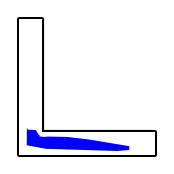

Sofa with vertices at:
[(3.872187482885212, -0.621423054391359), (3.8670492221602455, -0.7922772240481053), (3.329361994832866, -0.8333974064034443), (0.19233140338904792, -0.7390544874486308), (-0.6701154560986949, -0.5799184498874118), (-0.6622278929771672, 0.1817700475923655), (-0.6587588866841512, 0.20392515104829756), (-0.6533408146957814, 0.20351123000952387), (-0.6558345040646932, 0.15713604419197966), (-0.6215066835568724, 0.15529016649792327), (-0.623650102252663, 0.10961293989495793), (-0.2633696994376319, 0.09270666496207514), (-0.26517479662342386, 0.059806001139854376), (-0.22542327486450925, 0.057625031161689086), (-0.22409215507827035, -0.021297703251411546), (-0.1801136730032517, -0.02055595718680591), (-0.18016345913870188, -0.06872363937311232), (-0.1540212328441434, -0.06875065998859904), (-0.15339367408873816, -0.08184667734642453), (-0.1510710500253554, -0.08173537762631382), (-0.15117891248286985, -0.10316068002073574), (-0.12300042855255361, -0.10330254035343034)

 26%|██▌       | 2604976/10000000 [1:01:36<2:53:57, 708.51it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 27%|██▋       | 2659657/10000000 [1:02:52<2:51:03, 715.20it/s]

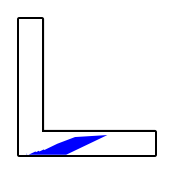

Disconnected Sofa with vertices at:
[(-0.6459105642112348, -1.0), (-0.6685815693866052, -1.0), (-0.6818233169304647, -0.9475869262566368), (-0.6728827482075163, -0.9432657348791377), (-0.6459105642112348, -1.0)]
[(-0.2768304567919208, -0.8520713694494984), (-0.2609503293885631, -0.8858401528862687), (-0.12788620022613462, -0.8232653394384362), (-0.11181786130511273, -0.8580020299915033), (0.0916441360704296, -0.7638855128643554), (0.09658893265232388, -0.7739863589269511), (0.09890501070866228, -0.772852539563167), (0.10843085071892256, -0.7925103479625506), (0.6840725326876934, -0.5135641676832089), (1.4699702079940662, -0.21618272520592272), (2.901112367402948, -0.12808102244790256), (1.0774946494440543, -1.0), (-0.587988876361327, -1.0), (-0.2768304567919208, -0.8520713694494984)]


 28%|██▊       | 2761234/10000000 [1:05:16<2:48:21, 716.61it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 28%|██▊       | 2766034/10000000 [1:05:24<2:54:28, 691.02it/s]

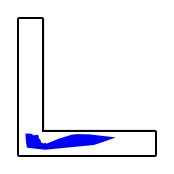

Sofa with vertices at:
[(-0.40810892128189874, -0.1397285484813551), (-0.1643388432227053, -0.11712063808069467), (-0.14460772683308243, -0.1767025874132523), (-0.11918002424958486, -0.3009862042864149), (-0.10444818209400632, -0.29797215536940225), (-0.1002611561218897, -0.3106156958766153), (-0.07897429978015004, -0.3035663555184522), (-0.07861805893907835, -0.3046640879357495), (-0.0694720956016724, -0.34698927620034614), (-0.06518326463566004, -0.3460625114915797), (-0.05978672036663342, -0.362691603113034), (-0.059436838596286415, -0.36257805797746145), (-0.050597103634274276, -0.38984549983637035), (-0.04913415846774968, -0.38937123284781383), (-0.04102530535859712, -0.41277915051544567), (-0.04003546214105043, -0.41637470887109673), (-0.039802013355383026, -0.416310441329234), (-0.019837053879540947, -0.4739435148795029), (-0.004772081450410935, -0.4687247828993334), (-0.0028631069698373604, -0.4740820857793585), (0.019370673137389816, -0.46615949491938846), (0.02578972396024266

 29%|██▊       | 2867963/10000000 [1:07:52<2:50:18, 697.94it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 29%|██▊       | 2873945/10000000 [1:08:01<2:52:13, 689.58it/s]

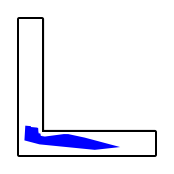

Sofa with vertices at:
[(1.899196613237722, -0.24136517804097485), (3.467046955632378, -0.659176093510899), (2.3426237304263697, -0.7835876192134401), (-0.10339621045057124, -0.5401380115152343), (-0.7709123045281805, -0.36466882254726535), (-0.7322234107076535, 0.2886165786545205), (-0.4826810413013619, 0.2657348841165835), (-0.4862479518570153, 0.22875796088525724), (-0.19758361187225082, 0.20091248886233293), (-0.1976240387711927, 0.19969496936132014), (-0.1974040811800765, 0.19968766582055564), (-0.19841871333948194, 0.18943998334604778), (-0.1636758307014246, 0.18600005962449506), (-0.1582318673437736, 0.10584485132128278), (-0.1587606213265324, 0.07238815301698213), (-0.15625607203454456, 0.07234857079637219), (-0.1562690791152737, 0.0659392509661604), (-0.15552146473451137, 0.06593773375671202), (-0.1501932163026794, -0.012513724287093797), (-0.14225083305815853, -0.011974295293383997), (-0.14004884661193565, -0.05442747706966507), (-0.08736668692385804, -0.05169492801828321), (

/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 30%|██▉       | 2980586/10000000 [1:10:38<2:58:39, 654.85it/s]

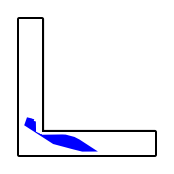

Sofa with vertices at:
[(-0.09093905115130742, -0.08351765503128974), (0.0013980977111688192, -0.08378594930652114), (0.0018607268651267134, -0.11484660107093111), (0.9031368117808475, -0.10142265247482368), (1.0572185737557305, -0.10862237157952928), (1.4426738703094903, -0.21068682763143187), (1.662612645285589, -0.3229035367479016), (2.4828308337271676, -0.8571318032289543), (1.7879420375396504, -0.8611515324577936), (1.3852524602047829, -0.7609675160882956), (0.5010133757582251, -0.5246375004644339), (-0.7813866153858318, 0.3048290093146977), (-0.656981240402095, 0.6582085909015603), (-0.43430734240537905, 0.6046128397278614), (-0.43600883565953974, 0.5985175763830728), (-0.33658718069466886, 0.570764013383242), (-0.3575506926736344, 0.4985409502514814), (-0.26456675521369455, 0.4715513737607106), (-0.2562850910845935, 0.008629405756982789), (-0.19785754049947124, 0.009674673390140665), (-0.19821876718752768, -0.026448913515483286), (-0.16991123794552723, -0.026731981613395683), (-

 30%|██▉       | 2986626/10000000 [1:10:47<2:56:38, 661.71it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 31%|███       | 3087365/10000000 [1:13:15<2:51:45, 670.75it/s]

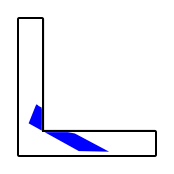

Disconnected Sofa with vertices at:
[(-0.001716424959275334, 1.0832933321967968), (-0.018770769404459764, 1.0516568785587093), (0.0, 1.0415380716093945), (0.0, 0.3529968195342597), (-0.004875378690064686, 0.21886333501936395), (-0.0009960911808670064, 0.21872233371962602), (-0.0020403924865946416, 0.09632633066602446), (0.0, 0.09630892172713114), (0.0, 0.06790737099147937), (-0.584863553921942, 0.39124375248091114), (-0.2793844548664963, 1.1575593442813967), (-0.2396996458736593, 1.2334709935623804), (-0.16272962708117236, 1.1893424608995202), (-0.1692045736732847, 1.1778766213471283), (-0.001716424959275334, 1.0832933321967968)]
[(1.46174578531268, -0.058092396202519964), (2.978966693772772, -0.8649101192611981), (1.670260501729522, -0.838233569106888), (1.632462354441013, -0.8345842735351039), (0.12283352140152082, 0.0), (1.1440843219552082, 0.0), (1.46174578531268, -0.058092396202519964)]


 32%|███▏      | 3163565/10000000 [1:15:06<2:44:47, 691.45it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 32%|███▏      | 3189494/10000000 [1:15:43<2:45:20, 686.48it/s]

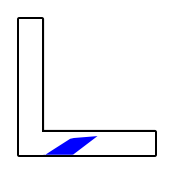

Disconnected Sofa with vertices at:
[(0.4504938256125369, -0.8070021406663015), (1.2547576813353576, -0.294099159647501), (1.4169835747815085, -0.2587344986737362), (2.464795263050878, -0.17417657707550885), (1.3845063848182948, -0.9952271415463958), (1.2996580095218382, -1.0), (0.15672912716740875, -1.0), (0.2103265067401259, -0.9632923069104078), (0.21086990783832996, -0.9641210543667624), (0.4504938256125369, -0.8070021406663015)]
[(0.09709726458441009, -0.9834136442515389), (0.10842522337133162, -1.0), (0.07344688964765435, -1.0), (0.09709726458441009, -0.9834136442515389)]
[(0.13742667319637958, -0.9828931570529393), (0.14898036426470793, -0.9996415243445784), (0.15220433520225032, -0.9974175007381565), (0.15397303343084962, -1.0), (0.11237889643535304, -1.0), (0.13742667319637958, -0.9828931570529393)]


 32%|███▏      | 3210962/10000000 [1:16:14<2:43:55, 690.23it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 33%|███▎      | 3296938/10000000 [1:18:19<2:43:11, 684.56it/s]

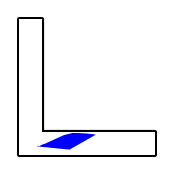

Sofa with vertices at:
[(2.393775130681901, -0.10801489444946547), (1.2237668991857495, -0.7743882861498042), (-0.2326001334874626, -0.6271426790246835), (-0.16072433243556847, -0.5913891485767445), (-0.14071162919296953, -0.6316685756419239), (0.07191794336322851, -0.5260242592696465), (0.07621167320843053, -0.5355338448394975), (0.10176949405668434, -0.5239940803199622), (0.10385465953265485, -0.528562847865213), (0.9671510881292953, -0.13455814296193924), (0.9851496656639496, -0.12891641352922809), (1.3504135297030935, -0.035215812914726835), (1.635105200221384, -0.03930412109904011), (2.000462010351414, -0.060167268074401925), (2.393775130681901, -0.10801489444946547)]


 34%|███▎      | 3356586/10000000 [1:19:46<2:42:08, 682.90it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 34%|███▍      | 3405113/10000000 [1:20:55<2:40:15, 685.87it/s]

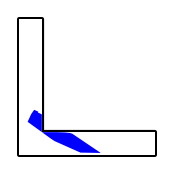

Disconnected Sofa with vertices at:
[(1.34930083515989, -0.07006518535605888), (2.6098751850403645, -0.9211507354033032), (1.7106325793588018, -0.905454397334912), (0.5602301178543206, -0.39372941358240643), (0.38324861105862007, -0.27500351100879683), (0.0036360869727146417, 0.0), (0.6444275755516, 0.0), (1.0387453748352817, -0.013602920269132734), (1.2540631690810535, -0.03797923421731411), (1.34930083515989, -0.07006518535605888)]
[(-0.627444029677635, 0.4571747157831215), (-0.6250066714557904, 0.46609878960615725), (-0.47168070741788837, 0.7991322713369674), (-0.34003153655717366, 0.9891580615736347), (-0.15951163953186784, 0.90892313663052), (-0.17677652906357086, 0.8732443508609636), (0.0, 0.7877025595625456), (0.0, 0.0026340982459355233), (-0.627444029677635, 0.4571747157831215)]


 35%|███▌      | 3511854/10000000 [1:23:31<2:39:55, 676.15it/s]

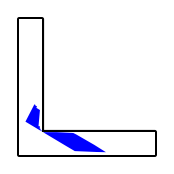

Disconnected Sofa with vertices at:
[(1.3313507788221741, -0.032693746452629346), (1.3962695255123674, -0.03860723480997108), (1.528528787813259, -0.10539918415261743), (2.321255376877008, -0.5621817396013223), (2.8391438444031136, -0.8881002714425662), (2.434602785603656, -0.8788227882439057), (1.459434400010207, -0.8383805525838706), (1.0826090959156323, -0.6168908439021662), (0.051183645125011556, 0.0), (0.6496564444779835, 0.0), (0.7008118832345713, -0.0023285852995431205), (1.3313507788221741, -0.032693746452629346)]
[(-0.7259558845303635, 0.4648035976922553), (-0.3299623542589416, 1.2327950884772532), (-0.2831251373838491, 1.2058804928281555), (-0.29480953295346574, 1.1871418032300782), (-0.21133983813364338, 1.1350947842939167), (-0.24599575311108351, 1.0788527721048817), (-0.0845764164819287, 0.9793873620279363), (-0.14694569371894212, 0.2649554794708203), (-0.08501395236017392, 0.2595488927256283), (-0.09381923429059762, 0.15129142465727266), (-0.05825321918477358, 0.148398610

 36%|███▌      | 3579821/10000000 [1:25:13<2:44:26, 650.70it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 36%|███▌      | 3617284/10000000 [1:26:09<2:42:24, 654.99it/s]

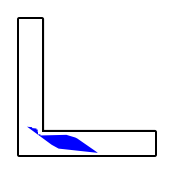

Sofa with vertices at:
[(-0.2385514319372525, 0.11738788006731597), (-0.18255191808382848, 0.11228063688681918), (-0.18530456761611386, 0.0058824161889078075), (-0.17156801725514653, 0.005527035162060712), (-0.16723118462247993, -0.09996418559488732), (-0.06301767063734315, -0.09567988056009297), (-0.06180915316821353, -0.1460919174743425), (1.087190641003887, -0.11854717998148341), (1.480651193722303, -0.23719060325894842), (1.5665766586412846, -0.2792927345728513), (2.3361971978648577, -0.8130999430784414), (2.476515967947797, -0.91254096183057), (2.4413965356175122, -0.9133960948809683), (0.7427448309023745, -0.7282312985669619), (0.44039842849464406, -0.5615993039710444), (0.43095012406238253, -0.5555608054913165), (-0.6581361992485295, 0.2451673282562753), (-0.629250535664643, 0.24266117718610036), (-0.6296775244601347, 0.23791026345148758), (-0.42801775217173876, 0.21978607343703394), (-0.4318696896572378, 0.180147257641805), (-0.2345762105629116, 0.16097508681576345), (-0.238551

 37%|███▋      | 3699748/10000000 [1:28:11<2:31:13, 694.37it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 37%|███▋      | 3726990/10000000 [1:28:52<2:36:03, 669.91it/s]

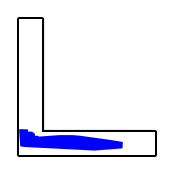

Disconnected Sofa with vertices at:
[(-0.17388801953829977, -0.1622138294435889), (-0.14856818209828282, -0.15993686991992823), (-0.1458439184298772, -0.19728590648916952), (0.7725297040398827, -0.13029912119209922), (1.3722362517171458, -0.13123816486540463), (1.676101504385464, -0.15650239848756353), (2.9814682199584617, -0.33712716882491955), (3.5867320114099193, -0.4339697143809893), (3.5723349849963517, -0.7141261816495877), (3.395958079681256, -0.731464701376558), (2.329707609646006, -0.8157844947507641), (-0.761476246445862, -0.6569309224622436), (-0.9562140750814567, -0.62657853584399), (-1.0, -0.0017671631914408237), (-1.0, 0.13593082659761008), (-0.6108527827361466, 0.12164616428977498), (-0.6115068739146062, 0.024277543019070428), (-0.4198471850484379, 0.022990034680993886), (-0.419907959053485, -0.003012163669827036), (-0.36917636355214634, -0.00313073680735252), (-0.36944959772704083, -0.04280226825518422), (-0.3390137799590966, -0.04301189226644752), (-0.3381211520028887,

 38%|███▊      | 3806629/10000000 [1:30:50<2:33:47, 671.17it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 38%|███▊      | 3834505/10000000 [1:31:30<2:29:33, 687.08it/s]

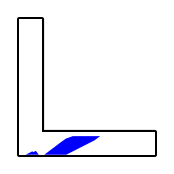

Disconnected Sofa with vertices at:
[(-0.41278542674169016, -0.8441500040905653), (-0.39065989247097443, -0.8896950611385521), (-0.26461033457973343, -0.8284608901067135), (-0.13310322986036566, -1.0), (-0.7164274753481016, -1.0), (-0.41278542674169016, -0.8441500040905653)]
[(-0.031152336082736688, -0.9917164478473395), (-0.02488006719173514, -1.0), (-0.04230882110381337, -1.0), (-0.031152336082736688, -0.9917164478473395)]
[(0.8121948731819154, -0.4679835573517285), (1.0617675239167192, -0.2876011747393563), (1.3698391351062371, -0.1773503666622285), (2.583265178928278, -0.17572780366708657), (2.328144971011076, -0.3650765818630113), (1.0782827878727237, -1.0), (0.10736197225630367, -1.0), (0.8121948731819154, -0.4679835573517285)]


 39%|███▊      | 3850028/10000000 [1:31:53<2:29:48, 684.19it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 39%|███▉      | 3943036/10000000 [1:34:11<2:29:10, 676.71it/s]

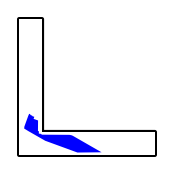

Sofa with vertices at:
[(-0.17202802773381692, 0.047528618054734156), (-0.1324283788222729, 0.04714285575583177), (-0.13213184742957215, -0.06783394382230143), (-0.05571611772200566, -0.06763686351707827), (-0.05615968975817871, -0.08470884668403314), (-0.03591934074899723, -0.08523474064345554), (-0.035930486070662286, -0.08647382795693749), (-0.016881903940257327, -0.08664516582215165), (-0.01684613899997702, -0.10530508175271068), (0.008903302317910844, -0.10525572851690765), (0.008865596688419138, -0.1119311183681336), (1.2228249559455462, -0.11878811141846819), (1.3113031127269192, -0.1364563568873542), (1.3564925248695985, -0.15384393704996863), (1.3789222848932712, -0.16496488317171923), (2.644152537595096, -0.8914698701427044), (1.5773986417339065, -0.9020861316267514), (0.15179549251040725, -0.3815932066206068), (-0.584973897508524, 0.03961628607087628), (-0.7812123492697961, 0.15944561817944744), (-0.7735959888234049, 0.24626921977641822), (-0.601363038153889, 0.7240394865958

 40%|███▉      | 3991572/10000000 [1:35:22<2:27:55, 676.94it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 41%|████      | 4050824/10000000 [1:36:51<2:25:45, 680.22it/s]

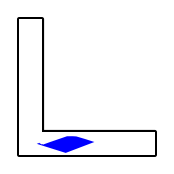

Sofa with vertices at:
[(-0.013317409244279071, -0.5374459954246062), (-0.01220589415894005, -0.5407040463366486), (0.0342537782889647, -0.5248538867842524), (0.04478460618601216, -0.5538326661313139), (0.32765814274143606, -0.45103701368445026), (1.1130546661541036, -0.1813625378593966), (1.3632483258344756, -0.1796135776166693), (1.5244651339807673, -0.18907563177546394), (1.5731430173074668, -0.2023665010936197), (1.9126842251668899, -0.30318630182447137), (1.9649701703737117, -0.31962719072546564), (2.3263388121370223, -0.43529322205095144), (1.0562489171671745, -0.9191017609723487), (-0.2249405303104588, -0.5165204744490468), (-0.09739309260243702, -0.47070488558741086), (-0.0843116484756377, -0.5089069585497464), (-0.06532076909444227, -0.5024039573176197), (-0.0592798973362194, -0.5205865444511969), (-0.03747282023418007, -0.5133414942706416), (-0.027819796178426906, -0.5422830501593119), (-0.013317409244279071, -0.5374459954246062)]


 41%|████      | 4102850/10000000 [1:38:09<2:27:48, 664.95it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 42%|████▏     | 4159022/10000000 [1:39:30<2:23:19, 679.21it/s]

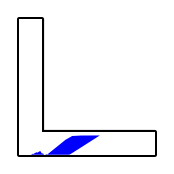

Disconnected Sofa with vertices at:
[(0.23645775259182303, -0.993250026342014), (1.0437822684793303, -0.34134705209444527), (1.344341031262668, -0.17034173217715434), (1.733704853288376, -0.14899418526812896), (2.567951754748774, -0.14562625445713728), (1.5870938863363424, -0.7712067506601682), (1.2982460758586898, -0.9526297114297241), (1.2265651092415337, -0.9940528589524443), (1.1441509659772158, -1.0), (0.14798482650115755, -1.0), (0.17233679144013436, -0.980598025743317), (0.1816765295260948, -0.9922869744131001), (0.21450146669636863, -0.9660590967382717), (0.23645775259182303, -0.993250026342014)]
[(-0.40428532767903586, -0.9534276352248733), (-0.39218449294470764, -0.9750945000102526), (-0.2312639029434906, -0.8852211618856841), (-0.21410941826683264, -0.9152259722704262), (-0.07093880072792624, -0.8333718251111523), (0.0029342984539698427, -0.9484503672238848), (0.02745293403221171, -0.9327109638162382), (0.04573813444379878, -0.9557747926893244), (0.05409993256970793, -0.9491

 43%|████▎     | 4268674/10000000 [1:42:12<2:20:47, 678.48it/s]

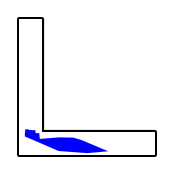

Sofa with vertices at:
[(-0.11355530812821554, -0.09569323939930807), (-0.10696182543483387, -0.09601340336584849), (-0.09068180307436668, -0.2996001859559875), (0.7726767330687797, -0.23056085002912002), (1.3958181182020002, -0.24331212645332823), (1.4419060614402093, -0.25489401369605635), (1.7589691260788658, -0.3506345501494114), (2.9401283004760557, -0.846642828272251), (2.0126490066095877, -0.9285138159193124), (0.744687252202058, -0.8346257918055392), (-0.7552846429462606, -0.18793833473390864), (-0.7500772404910034, -0.04892672442850299), (-0.7358053688382206, 0.1020783826897811), (-0.7296352065928572, 0.13134694806542085), (-0.5721910105416842, 0.1215468645386416), (-0.5734057242889464, 0.09686556033103351), (-0.2791277103527662, 0.08238238934300472), (-0.2834490276529471, -0.03960541830429192), (-0.11112822731493666, -0.045709740285673844), (-0.11355530812821554, -0.09569323939930807)]


 43%|████▎     | 4285887/10000000 [1:42:37<2:20:51, 676.15it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 44%|████▍     | 4375910/10000000 [1:44:49<2:12:21, 708.22it/s]

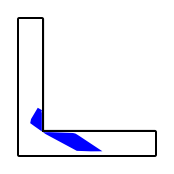

Disconnected Sofa with vertices at:
[(0.3286214386475712, -6.758058054610883e-05), (1.264202047093787, -0.03176243506385837), (1.3799490155665501, -0.03737907617757019), (1.4647325273558758, -0.05654038933597111), (1.494575740741614, -0.06532039403548903), (1.6489114882966753, -0.16175753813570007), (2.682002548300985, -0.8468805673838079), (2.1658230459638386, -0.8492888528688621), (1.54878864072918, -0.8269504927725558), (0.16726758266562075, -0.08510250213731615), (0.046057906918154035, 0.0), (0.13271919116068295, 0.0), (0.13281387225197946, -0.0043396486082120656), (0.3286214386475712, -6.758058054610883e-05)]
[(-0.3352497960668729, 0.26771987803899866), (-0.515584317315066, 0.3992999904804384), (-0.47823521549118186, 0.5798846042561222), (-0.18095376516055833, 1.0797486707295239), (0.0, 0.9780702725245297), (0.0, 0.9350881591432888), (-0.0260673703352044, 0.8901136980269185), (0.0, 0.8750049500991898), (0.0, 0.03233770817198503), (-0.3352497960668729, 0.26771987803899866)]


 44%|████▍     | 4417454/10000000 [1:45:49<2:14:05, 693.86it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 45%|████▍     | 4483266/10000000 [1:47:26<2:18:26, 664.13it/s]

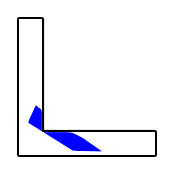

Disconnected Sofa with vertices at:
[(0.0, 0.9521031053605956), (0.0, 0.04004194969673325), (-0.6014321780588587, 0.41588795408504897), (-0.5487762747167017, 0.5791217099706052), (-0.32662679979877207, 1.0692067503754128), (-0.26255176093235566, 1.1864853228586296), (-0.1861589325749267, 1.1429732051131845), (-0.2002785419515212, 1.1186859450391888), (-0.02728363329646477, 1.0181138538725472), (-0.04907623782482037, 0.9806525075429097), (0.0, 0.9521031053605956)]
[(1.221485412390944, -0.006783067548195992), (1.351400785855376, -0.030908697265365326), (1.470907632014232, -0.08365571986061762), (1.8027743911293812, -0.2511095254577568), (2.6663637093588957, -0.8515619811333072), (1.5254497578914883, -0.8308257843785724), (1.3638012779324034, -0.8122224947248112), (0.06407549033020465, 0.0), (1.0568237727926013, 0.0), (1.221485412390944, -0.006783067548195992)]


 46%|████▌     | 4567918/10000000 [1:49:30<2:10:12, 695.31it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 46%|████▌     | 4590613/10000000 [1:50:04<2:13:04, 677.48it/s]

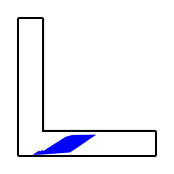

Disconnected Sofa with vertices at:
[(0.04387115819345245, -0.8204814956030204), (0.06386388486241922, -0.8081219753046767), (0.07672637689184574, -0.827967763402521), (0.27094470088877726, -0.7020905932915337), (1.022094006514654, -0.2244139272527082), (1.1094146080259404, -0.18743108650811036), (1.2901911507656965, -0.1400991475572155), (1.391335912791268, -0.12201891142403157), (2.412252231607561, -0.10901661209551113), (1.439960921795367, -0.7719187427785617), (1.2415702626065228, -0.8989252355927263), (-0.08909696489795854, -1.0), (-0.4094976285484684, -1.0), (-0.1135971258991328, -0.8117764908953565), (-0.0854428697025724, -0.8564524843294441), (0.02361961811275692, -0.7877226590393298), (0.04387115819345245, -0.8204814956030204)]
[(-0.4776975944214336, -0.9871460017857385), (-0.46952111405640956, -1.0), (-0.49700254532970595, -1.0), (-0.4776975944214336, -0.9871460017857385)]


 47%|████▋     | 4699681/10000000 [1:52:45<2:10:17, 678.00it/s]

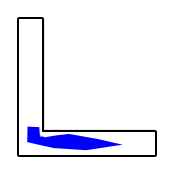

Sofa with vertices at:
[(-0.13735987314344705, -0.5586727917327714), (-0.6478195975840979, -0.4397684100018204), (-0.6333616549675125, 0.24675221041225048), (-0.13072233704212533, 0.2227656229664128), (-0.13086636064782897, 0.22166071886716487), (-0.11333651544363661, 0.21937571375636597), (-0.11201471893577854, 0.20844450743974544), (-0.09062015450604778, -0.10629258024987717), (-0.07409270256883359, -0.10516911037879972), (-0.06243690943053452, -0.20156207164107873), (0.031000579491083854, -0.19026365287719088), (0.032011439821281996, -0.19785314496433323), (0.07891864171382774, -0.19160547660269256), (0.0810851399584223, -0.20808998804427228), (0.09506048449086275, -0.20625326030718194), (0.09895785238938115, -0.23044551126801385), (0.6412635921602793, -0.143080140232994), (1.2049358954883032, -0.07954303354339971), (2.444333533538053, -0.29680655663838307), (3.576440670068096, -0.5536381266555364), (2.061312225570484, -0.7836345740731017), (1.9345671341863955, -0.7966475278590714),

 47%|████▋     | 4730779/10000000 [1:53:31<2:07:06, 690.92it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 48%|████▊     | 4809057/10000000 [1:55:27<2:07:01, 681.05it/s]

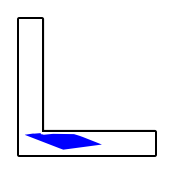

Sofa with vertices at:
[(-0.3612986581630087, -0.05959670283162416), (-0.3606452162440065, -0.06764169874416032), (-0.047675201659896, -0.0422212101393839), (-0.045193206609146386, -0.08471478483278685), (-0.018170300797032163, -0.08313641165598235), (-0.017000552421979467, -0.09952512498500654), (0.03471551789913143, -0.09583387796593049), (0.03485114201674388, -0.09831793551945564), (0.04749250262984583, -0.09762774483682293), (0.048520391257726225, -0.10954305590027691), (0.07412578074779458, -0.10733417620514116), (0.0749492164573354, -0.11571387159402463), (0.4283723501896487, -0.08098453891697496), (0.5057590450366382, -0.07476013888251412), (1.427658043960401, -0.08750701093018987), (1.6692847161698665, -0.16190362154591817), (1.8166419089488728, -0.21550566529432527), (2.6600417565073133, -0.548351177832292), (0.9494044077375575, -0.7753947856956372), (0.7812630667834737, -0.7133319680508233), (-0.7479310626687742, -0.12249697288150882), (-0.7473872276752233, -0.113018347260251

 49%|████▉     | 4915515/10000000 [1:58:04<2:02:07, 693.91it/s]

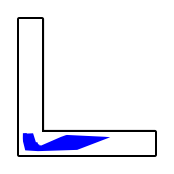

Sofa with vertices at:
[(1.5643302613727654, -0.7847238988826943), (-0.17163658722239095, -0.8404296002139254), (-0.7353628113574289, -0.8054916383236553), (-0.8338464254522456, -0.40930813128208215), (-0.841766508202089, -0.26119648963753467), (-0.8382373351530942, -0.046945226423854874), (-0.6680746453865285, -0.03850366877546879), (-0.6668924127407585, -0.06282507363596031), (-0.3883964248789092, -0.04928773685568627), (-0.2608921328308442, -0.45293693388616385), (-0.2052116442390675, -0.43534863857673883), (-0.19170685283203984, -0.47051706013936523), (-0.18889374222857602, -0.46943681626669076), (-0.16488544873470187, -0.5259425325598973), (-0.1596432278041495, -0.5237152043015068), (-0.1497606298083224, -0.5485773514432378), (-0.12669207418316017, -0.5394076984648284), (-0.12089191706860603, -0.5543079748718297), (-0.11588764087558695, -0.5523599849573257), (-0.1144152886115748, -0.5562227551264857), (-0.10836783497122121, -0.5539176782855234), (-0.09013716021027512, -0.597312427

 50%|████▉     | 4986306/10000000 [1:59:50<2:05:13, 667.32it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 50%|█████     | 5025004/10000000 [2:00:47<2:03:14, 672.79it/s]

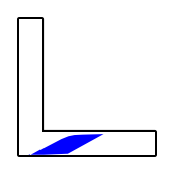

Disconnected Sofa with vertices at:
[(-0.5232172717759529, -1.0), (-0.5951870434911397, -1.0), (-0.540412810095855, -0.9691393556717123), (-0.5232172717759529, -1.0)]
[(-0.07952367711864528, -0.7678086590392851), (-0.06641346065967957, -0.7914649484714417), (0.08826985007646768, -0.7057401059446238), (0.09242400993898404, -0.7136738991860907), (0.8683203309527301, -0.307412070054637), (1.1801091670555852, -0.18198652785429636), (1.440968778742986, -0.12925617525960192), (1.540729796179798, -0.12346738325378032), (1.8052986074889243, -0.11051245741948984), (2.730556756327887, -0.0861546058034467), (1.1512874671178268, -0.954898350485703), (0.08894531012902207, -1.0), (-0.4962349342011394, -1.0), (-0.07952367711864528, -0.7678086590392851)]


 50%|█████     | 5040292/10000000 [2:01:08<1:57:49, 701.60it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 51%|█████▏    | 5131675/10000000 [2:03:20<1:57:49, 688.66it/s]

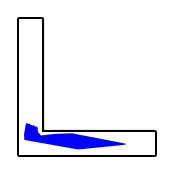

Sofa with vertices at:
[(-0.31714159982000684, 0.29062640570175013), (-0.3216926453012944, 0.2569957232766663), (-0.22124941330568298, 0.24340332240528476), (-0.22247449068419015, 0.2196146056727392), (-0.18393194285884673, 0.2176297317519756), (-0.17696766191924304, 0.03591711713625767), (-0.16215564055164217, 0.036484799673353566), (-0.15587093298040663, -0.02214433437543417), (-0.14426579764346043, -0.020900330296222763), (-0.14239321073814182, -0.03828192699064842), (-0.13342276329163152, -0.03731550585463253), (-0.13236384765195747, -0.05933455467138385), (-0.09196423538819892, -0.05739170138926056), (-0.08807826506120106, -0.09485276368008755), (-0.08286706908713262, -0.0943121876343209), (-0.08261445107317697, -0.10125485164727255), (-0.08054034397747986, -0.10117938251694025), (-0.08013492312131124, -0.10473045916956361), (-0.0606629122199296, -0.10250737020156672), (-0.05491386730494977, -0.1491284725604055), (0.06847469613536747, -0.13391290799152777), (0.06861034501979729, -

 52%|█████▏    | 5186255/10000000 [2:04:38<1:53:32, 706.59it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 52%|█████▏    | 5241192/10000000 [2:05:56<1:54:06, 695.03it/s]

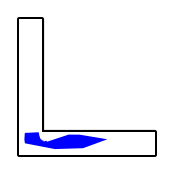

Sofa with vertices at:
[(-0.008457921443336014, -0.35193736030034606), (0.012290744559412273, -0.3461703737676385), (0.01702072659069373, -0.3645143452913613), (0.031216889048658505, -0.3608538733345381), (0.03769243042880552, -0.3795656884562909), (0.07134414956918533, -0.3679199395864656), (0.08525136219567568, -0.41408073206648044), (0.20838567278267803, -0.37698312288459634), (0.2244829059889061, -0.425698330964394), (1.1855428657365146, -0.10813002104599023), (1.6711942895028589, -0.11104621487701022), (2.9045293169746818, -0.31531030238971813), (1.8259625925233929, -0.7097759028601153), (0.5767353228965046, -0.7483641904260447), (-0.7504278147060659, -0.49304967701283997), (-0.7733131292443772, -0.32360784364218487), (-0.7534596107924867, -0.03283535114270694), (-0.6158483848148515, -0.02587293241161434), (-0.6157311283321084, -0.02813696214378672), (-0.14339407646590174, -0.0036741290879825778), (-0.12302353239625391, -0.07899635493887519), (-0.10555686285339921, -0.179700209488

 52%|█████▏    | 5247249/10000000 [2:06:05<1:54:02, 694.60it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 54%|█████▎    | 5352373/10000000 [2:08:39<1:51:19, 695.82it/s]

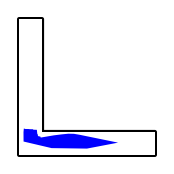

Sofa with vertices at:
[(-0.1740106830421562, -0.15444490241146655), (-0.17300689550918233, -0.15430943375177059), (-0.1693692274665243, -0.18104672489567236), (-0.1269878987533568, -0.17528065067986867), (-0.12462537652687894, -0.19090342347102696), (-0.09139029423242287, -0.18587751535157312), (-0.09136910090211314, -0.18604351405128455), (-0.06991113544461253, -0.18330393988283644), (-0.06592480743093806, -0.21535688834238645), (-0.055466055025395894, -0.2140561650172009), (-0.05111990185297935, -0.23973877934215368), (0.5334541533642617, -0.1408139443370878), (0.8715261556298798, -0.09876895446755521), (1.1722114544268707, -0.06856250926009741), (1.4189026587978497, -0.0731150525176405), (1.6594359413210704, -0.11334714403178925), (3.3757844567853437, -0.4640918156345867), (1.9965209130082964, -0.7274756359133748), (0.431841725250246, -0.7064369635033702), (-0.809302937853215, -0.41502247734240566), (-0.8122231151523154, -0.002376373073079356), (-0.797991883444835, 0.15588819528439

 54%|█████▍    | 5390308/10000000 [2:09:34<1:49:44, 700.08it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 55%|█████▍    | 5458758/10000000 [2:11:13<1:47:25, 704.51it/s]

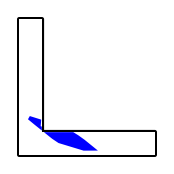

Disconnected Sofa with vertices at:
[(1.4003653131278042, -0.0051154305258727245), (1.6187185324234632, -0.14157785337825218), (1.890669600557188, -0.33608396914854083), (2.4820700361393992, -0.8155691069931595), (1.849645487277877, -0.8184410718311593), (0.7385445798269468, -0.48120316852792744), (0.45773222526643265, -0.29319442742384544), (0.09121499402070038, 0.0), (1.3809420098924172, 0.0), (1.4003653131278042, -0.0051154305258727245)]
[(-0.31334886826507025, 0.32362972282667307), (-0.6141315723184103, 0.5709393858409154), (-0.5324836908297654, 0.7129756006234674), (-0.02626700523319575, 0.5542907503668548), (-0.05146403265048746, 0.27556335860286285), (-0.04476769584993337, 0.27495800804549153), (-0.04737494475700477, 0.25766698792681286), (0.0, 0.25052349540338226), (0.0, 0.07296717770531871), (-0.31334886826507025, 0.32362972282667307)]


 55%|█████▍    | 5491376/10000000 [2:12:01<1:48:41, 691.33it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 56%|█████▌    | 5566665/10000000 [2:13:48<1:43:57, 710.79it/s]

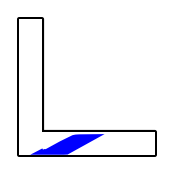

Disconnected Sofa with vertices at:
[(0.1739486176520914, -0.7423094640293617), (0.17775033937701318, -0.749240099811516), (0.7709254392636994, -0.42386062023643467), (0.8171427838506269, -0.39920663131412826), (1.3488264470187312, -0.13825587763914876), (1.3643821301764996, -0.13274716521801838), (1.4397630910582924, -0.1164161704580072), (1.4997469304539333, -0.10580950136822474), (1.6610569580264036, -0.09689348196194504), (2.777964516395218, -0.0856202420545979), (1.139419110231849, -0.9920607310453978), (0.9672525736886826, -1.0), (-0.5140201000978919, -1.0), (0.024178070951501034, -0.7202347779637831), (0.05113685315208401, -0.7751629353770008), (0.11187428559795382, -0.7453529564910735), (0.11617701783620293, -0.7537444418850157), (0.13342161784431067, -0.7449022771302334), (0.14132242576193188, -0.7597134447345731), (0.1739486176520914, -0.7423094640293617)]
[(-0.5546180632100334, -0.9657873133077933), (-0.5368336848829259, -1.0), (-0.538847503166845, -1.0), (-0.554618063210033

 56%|█████▌    | 5595564/10000000 [2:14:32<1:47:50, 680.66it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 57%|█████▋    | 5675264/10000000 [2:16:27<1:44:44, 688.11it/s]

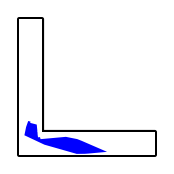

Sofa with vertices at:
[(1.9043918679702276, -0.9588107341341606), (1.543822707101986, -0.9618076003451841), (0.11393593761841683, -0.5541205910173973), (-0.772113061344501, -0.13772571940156147), (-0.6961783903196429, 0.23061637777621402), (-0.6037727887535485, 0.4939911533171711), (-0.5007322274623008, 0.4676245093876575), (-0.5153432033858254, 0.41148388626696597), (-0.22595758109892525, 0.3361693257078642), (-0.199996657898903, 0.06930494749727921), (-0.20280089833329795, 0.017128475105612398), (-0.1948794443156019, 0.01670273414158388), (-0.1903337055395551, -0.030025024445077084), (-0.18352558562887872, -0.1472429642092979), (-0.17895640449200811, -0.1469775821940878), (-0.17104520506860757, -0.22830047270762305), (-0.08045872565796316, -0.2194880989816534), (-0.07856069556383041, -0.2491322259330374), (-0.06710938025306899, -0.24839903041296446), (-0.06155019774607186, -0.30966169705758995), (1.065326262514174, -0.2074050985689045), (1.5688074782185075, -0.30747189452814155), (1

 57%|█████▋    | 5680241/10000000 [2:16:34<1:43:58, 692.43it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 58%|█████▊    | 5784886/10000000 [2:19:04<1:40:43, 697.48it/s]

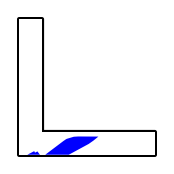

Disconnected Sofa with vertices at:
[(0.14213364433914943, -0.9979575417891648), (0.1436762949336032, -1.0), (0.13942999664062283, -1.0), (0.14213364433914943, -0.9979575417891648)]
[(0.9544790215755123, -0.3931272240271336), (1.0670632461980356, -0.3158871105552522), (1.105706785613724, -0.29504723266392474), (1.4154026305532739, -0.20307888949196948), (1.6068382041024227, -0.19121805830528038), (2.5039537323701477, -0.19573054803432904), (2.2824749243469458, -0.3758252554444629), (2.073826377882956, -0.521774788334307), (1.191534891562518, -1.0), (0.15098386286975046, -1.0), (0.9544790215755123, -0.3931272240271336)]
[(-0.33734902419122864, -0.8402697012899789), (-0.302524471947462, -0.9080736800497227), (-0.19520163782748415, -0.852951993798784), (-0.08389829230713378, -1.0), (-0.6427717560764994, -1.0), (-0.33734902419122864, -0.8402697012899789)]


 58%|█████▊    | 5801134/10000000 [2:19:27<1:39:05, 706.21it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 59%|█████▉    | 5891765/10000000 [2:21:37<1:39:37, 687.28it/s]

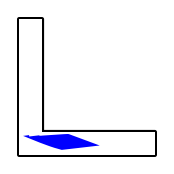

Sofa with vertices at:
[(-0.04786670368545914, -0.1595603548417933), (0.033160438515431934, -0.15113161414628049), (0.962378504555888, -0.08969354583421627), (1.1297403697370252, -0.08141846828654464), (1.193799783603843, -0.08540028339281239), (2.562997000081766, -0.5910524116086037), (0.8822586421025388, -0.7848761609996732), (0.559344558587262, -0.6937507364145509), (0.3822601323986131, -0.6356964628401883), (0.2153123594811128, -0.5759256813953036), (-0.09221700852061873, -0.46196118106425355), (-0.8303860300378444, -0.16544504285561953), (-0.5649173340255781, -0.1306786840902911), (-0.5577174037366515, -0.19140637337014885), (-0.1102199604477619, -0.13835066790268352), (-0.10875451490545607, -0.16051475134671497), (-0.04818401805466447, -0.1565099493963252), (-0.04786670368545914, -0.1595603548417933)]


 59%|█████▉    | 5908317/10000000 [2:22:00<1:36:00, 710.24it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 60%|██████    | 6002876/10000000 [2:24:17<1:35:31, 697.42it/s]

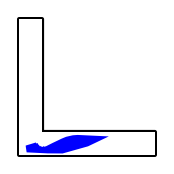

Sofa with vertices at:
[(-0.5452206043047855, -0.543057905156636), (-0.2635261225143771, -0.4575011558668223), (-0.24932895494160465, -0.5015623426257667), (-0.18786668542240934, -0.48175828821977185), (-0.17121760596441346, -0.5191505921939009), (-0.17112497383748335, -0.5193945357006315), (-0.17111130086294782, -0.5193893436923286), (-0.1512600778764531, -0.5639733680548713), (-0.12840039091684174, -0.5537949969965185), (-0.09869089922581081, -0.6237820338735566), (-0.061231010764184246, -0.607880314145758), (-0.05050105382177325, -0.6326317368466478), (-0.02975810767199355, -0.6236394893408964), (-0.018790966276924073, -0.6482986314745739), (0.0025241959745129078, -0.6388187234954931), (0.012071120862565177, -0.6583625416238447), (0.0977254007584089, -0.6165214350838907), (0.11459849994384623, -0.651786639438602), (0.1755589981250516, -0.6226192901767298), (0.17834259245734868, -0.6281606621589656), (0.46633053817131465, -0.4834958361863827), (0.8763372357511424, -0.2873227584587439

 60%|██████    | 6034134/10000000 [2:25:02<1:33:31, 706.76it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 61%|██████    | 6108151/10000000 [2:26:49<1:33:50, 691.23it/s]

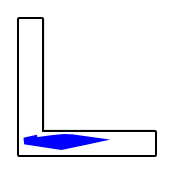

Sofa with vertices at:
[(0.8787969680166299, -0.788076512737499), (0.8059151180797314, -0.7806085612608983), (-0.7828490770752751, -0.538721465955959), (-0.8072154499739831, -0.3044982480986482), (-0.8103156353965267, -0.24612422157585986), (-0.21448313285327447, -0.11364735505349136), (-0.19912507346016567, -0.22068560404825047), (0.30008501681305644, -0.14905795423093474), (0.6367271700074953, -0.11347915013337964), (0.9852286547224364, -0.08235585022271599), (1.3692100236670688, -0.09801561346302942), (3.030951406583498, -0.32931400136544), (1.959855427052541, -0.560510029590649), (0.8787969680166299, -0.788076512737499)]


 62%|██████▏   | 6152315/10000000 [2:27:52<1:30:51, 705.74it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 62%|██████▏   | 6218522/10000000 [2:29:27<1:29:32, 703.88it/s]

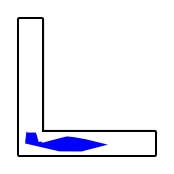

Sofa with vertices at:
[(1.9442019473719077, -0.31310463175849323), (2.924326243214615, -0.5527504126113805), (1.7548216870671076, -0.855693109736342), (0.7726632916829121, -0.8494999923268189), (-0.7389410586543195, -0.5005207777024134), (-0.729995362245851, -0.3742028103854045), (-0.6838525224687755, 0.02097417392602091), (-0.6494081313367447, 0.020740057685427887), (-0.6496594286559799, -0.01617719008124839), (-0.2554640452621304, -0.01886049528672959), (-0.2548179486297, -0.08083995833308617), (-0.2385366355642574, -0.08067023596012386), (-0.14155030999670462, -0.435764525620315), (-0.0268252377696008, -0.4044298533099644), (-0.01410234531792666, -0.4574116241236308), (0.03861972908948138, -0.44475109443175476), (0.044050318206290205, -0.46521527354068115), (0.9067298876019199, -0.2362855785885117), (0.9752202188478167, -0.2198385043394136), (1.128919659761344, -0.18847221163015415), (1.1428235633904613, -0.18901747294748233), (1.4655798360804024, -0.22789038599477027), (1.94420194

 62%|██████▏   | 6223609/10000000 [2:29:34<1:30:22, 696.44it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 63%|██████▎   | 6326023/10000000 [2:32:01<1:27:01, 703.67it/s]

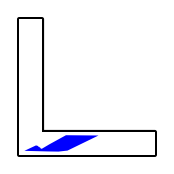

Sofa with vertices at:
[(0.2640089283176347, -0.8536037221774867), (-0.7728692843800572, -0.8266986328700161), (-0.24591118825226477, -0.5810221020363895), (-0.23501718627144813, -0.6021117311161915), (-0.21968892387368474, -0.5941938051872032), (-0.21192642646784884, -0.609432411035822), (-0.19663538919268714, -0.60164320522788), (-0.19233334280256778, -0.6101077745831407), (-0.17397404442397324, -0.6007768151450626), (-0.13978402605441476, -0.658014611255286), (-0.11894616350726678, -0.6455674705251059), (-0.10278077345675452, -0.6767245204364426), (-0.08677907455517492, -0.6684222676573467), (-0.07417187803755697, -0.6920554342112525), (-0.06567583108750329, -0.6875231878329268), (-0.03593799257410775, -0.7416863439424523), (-0.0022015366375200615, -0.7231636183348886), (0.0036836914361587925, -0.7331519957545637), (0.33280992724284597, -0.5392283101178951), (1.0686463762532392, -0.13522331733842513), (2.5084580381610784, -0.14804037852566493), (1.1367826472639104, -0.81564739965189

 64%|██████▍   | 6381580/10000000 [2:33:22<1:28:41, 679.91it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 64%|██████▍   | 6434618/10000000 [2:34:38<1:23:53, 708.35it/s]

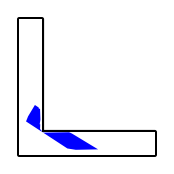

Disconnected Sofa with vertices at:
[(0.026481128434582613, 0.0), (0.06470670788246714, 0.0), (0.06498564983514671, -0.019860946047309952), (1.2073962127304747, -0.0038160792813112104), (1.3251464456833302, -0.056655872684717515), (2.490225289910904, -0.761398599205606), (2.4511083361252393, -0.7626982942525445), (1.5039257542192221, -0.7815012508386443), (1.1305564572163795, -0.7223246387171254), (0.026481128434582613, 0.0)]
[(-0.6994820674247566, 0.47495047620492803), (-0.6106364540293914, 0.697773421203974), (-0.30691887230956183, 1.2036117196965377), (-0.21719867522470845, 1.1434210591219098), (-0.21721768345907264, 1.14339123808088), (-0.21594534973526433, 1.1425802396456293), (-0.13363988403139487, 1.0873639058592344), (-0.148033901742094, 1.064867976180556), (-0.07898310350185095, 1.0206858318102285), (-0.06356882455111515, 0.5567618992110591), (-0.09522684349944993, 0.35041404254433706), (-0.07119353777586163, 0.34672683754846767), (-0.08035522712430845, 0.11827134665582047), (

 65%|██████▍   | 6472806/10000000 [2:35:33<1:23:49, 701.25it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 65%|██████▌   | 6543620/10000000 [2:37:16<1:23:46, 687.59it/s]

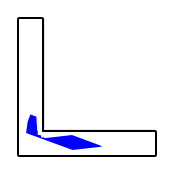

Sofa with vertices at:
[(-0.10611485949892818, -0.12526835350951201), (-0.10540965314372881, -0.1309879816982921), (-0.06842973680022031, -0.12642851189371), (-0.06781906993593902, -0.13245231539074323), (-0.05247569037494566, -0.13089687064746722), (-0.04832577220418999, -0.15919962428013695), (-0.03596667759872699, -0.15738746027860712), (-0.024567485308499348, -0.24184831645005003), (0.10350139079564334, -0.22456360242653703), (0.10849216158571683, -0.2680383999621613), (1.3353267292082507, -0.12720162851255146), (2.485843540533085, -0.5523198774402908), (2.682902374202271, -0.6396233887851556), (1.3573806037663017, -0.7886145314697969), (-0.6972610283058603, -0.03774727202869195), (-0.6273303286406526, 0.4675198011084398), (-0.5061238442352384, 0.7854109587655131), (-0.24238114011419448, 0.684283045680352), (-0.20578387376415705, 0.0659713347412204), (-0.18830470682880532, 0.0670059095626131), (-0.17715160938088617, -0.12930421161536398), (-0.10611485949892818, -0.12526835350951201

 66%|██████▌   | 6553968/10000000 [2:37:32<1:25:36, 670.93it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 67%|██████▋   | 6655223/10000000 [2:39:59<1:20:57, 688.63it/s]

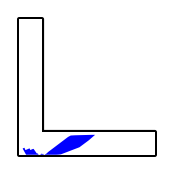

Disconnected Sofa with vertices at:
[(0.1776567954514467, -0.9712217214537382), (0.283027807582517, -0.8755901137177478), (1.1629284933651969, -0.21020038437473754), (1.2808660307434612, -0.1485463475523572), (1.4635986158893604, -0.1385487414094092), (2.2178524910431303, -0.11832076312983489), (2.358379039433091, -0.11838895087319447), (2.0758518089063553, -0.3623563468769721), (2.0648574819578878, -0.37082856864001873), (1.6657715834399693, -0.6680751188068554), (0.8445791133948664, -0.98245182926414), (0.7339559387849088, -0.9940660800016508), (0.6393971766121173, -1.0), (0.12643419206678375, -1.0), (0.1703637611997542, -0.9631859431289727), (0.1776567954514467, -0.9712217214537382)]
[(-0.8428238129575136, -0.7382072345727346), (-0.8459756978142005, -0.7199052233991474), (-0.7709758990766789, -0.6903264156257345), (-0.7259304562347757, -0.7949593818738447), (-0.5439208583757025, -0.716602595948487), (-0.5105268095471514, -0.7929612523439089), (-0.3965833564666839, -0.743130186483365

 67%|██████▋   | 6683551/10000000 [2:40:40<1:20:05, 690.11it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 68%|██████▊   | 6764241/10000000 [2:42:36<1:16:59, 700.41it/s]

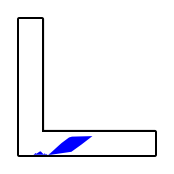

Disconnected Sofa with vertices at:
[(0.40029881494795067, -1.0), (0.28554305992350526, -1.0), (0.34101121664896417, -0.9511901766037594), (0.3476541902800893, -0.9584788113084753), (0.7652197928539839, -0.5779031068671336), (0.8779022469783743, -0.47874692410647246), (1.2050554237002342, -0.23478880935093774), (1.3363064907594209, -0.1977493928027808), (2.2400842588488676, -0.1747384106723912), (1.7642830122687874, -0.5413860122126055), (1.3077694898307795, -0.8695308115408328), (0.40029881494795067, -1.0)]
[(-0.26783719428478475, -0.9230644446361984), (-0.24610725062786673, -0.9568880325316885), (-0.08096338793668553, -0.8507914574831443), (-0.07194126463516695, -0.8626254112067557), (-0.05033182051596846, -0.8461505226045083), (0.038154357144792636, -0.9454371862720737), (0.043114080847201405, -0.941016985446826), (0.07855026933811862, -0.9805204491239925), (0.12882688301987227, -0.9354203137619014), (0.16710505325448113, -0.9776377770379517), (0.17363371005884562, -0.97171830634577

 68%|██████▊   | 6786134/10000000 [2:43:07<1:15:30, 709.31it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 69%|██████▊   | 6874485/10000000 [2:45:14<1:13:11, 711.76it/s]

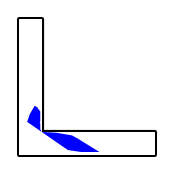

Disconnected Sofa with vertices at:
[(-0.5239264072214418, 0.8154638643942083), (-0.3152713868828888, 1.169165806779488), (-0.1609968562124648, 1.0712350925891405), (-0.18382935607878353, 1.0332342606174147), (-0.09939068650075154, 0.9824999526610285), (-0.11407469113712194, 0.9578309664460745), (-0.07082744331906797, 0.9320884092960949), (-0.06908053055291104, 0.49047092801486813), (-0.09376781985199863, 0.3922058166257371), (-0.06866687648750476, 0.38589966949213905), (-0.06842735956510294, 0.325350074775967), (-0.07390587852677964, 0.28990537778509773), (-0.0682837129734055, 0.2890363862798866), (-0.06754748387632266, 0.10291854124578942), (-0.037134799798123994, 0.10303884514751716), (-0.03780035085852522, 0.036720942810610994), (0.0, 0.03634158727144417), (0.0, 0.00468712173683844), (-0.6482816574852612, 0.45378909174374965), (-0.5642713928506389, 0.7207154365855601), (-0.5619889078354582, 0.7270336480524142), (-0.5542904611085924, 0.7465233831996426), (-0.5239264072214418, 0.8154

 69%|██████▉   | 6922692/10000000 [2:46:24<1:12:55, 703.33it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 70%|██████▉   | 6979549/10000000 [2:47:45<1:10:45, 711.45it/s]

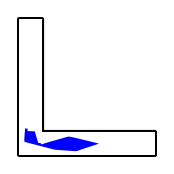

Sofa with vertices at:
[(-0.6284086425790235, 0.15519820431238204), (-0.6324492107408206, 0.04816177233210672), (-0.31350167413085617, 0.036121673107329416), (-0.1600528496953162, -0.47977087922999784), (-0.11591029089290561, -0.4666409673421088), (-0.10975960161050248, -0.48786264128867995), (-0.05474249203108321, -0.4719170025473224), (-0.03420152942436379, -0.5343452215136519), (-0.015987399456958155, -0.5283521663093017), (-0.010831842258383349, -0.543252922936529), (0.19089796603278691, -0.4734558252909975), (1.1588254827199023, -0.198155969449748), (1.254371550472888, -0.20356447167025943), (1.5104532951345153, -0.25812771204512586), (2.531127426018983, -0.5074969058269979), (1.5219039605818376, -0.8438032668973167), (0.5809183333768756, -0.7789443459768274), (-0.7658964715435908, -0.43145132450112555), (-0.7783902578288509, -0.3183385459586507), (-0.7413751840392389, 0.17725315596747301), (-0.7243820530860586, 0.17615919856768755), (-0.7251383325074378, 0.15962179248299244), (-0

 70%|███████   | 7001195/10000000 [2:48:17<1:11:46, 696.33it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 71%|███████   | 7087420/10000000 [2:50:22<1:08:36, 707.46it/s]

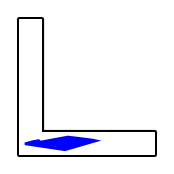

Sofa with vertices at:
[(1.1484118716583684, -0.1550222012828431), (2.051822034858152, -0.26349778419161635), (2.3060657833895664, -0.3022429820754325), (2.633042623955592, -0.37322632284189244), (1.0344988175856615, -0.8378803065183034), (0.9765474859914121, -0.8321492052029654), (-0.704554150545992, -0.58255986091989), (-0.7590358350170038, -0.5711343834868042), (-0.7660696931902007, -0.45835925394035465), (-0.3314120429607913, -0.33994426458563204), (-0.3285219907442536, -0.35235677680593597), (-0.14062989405126947, -0.3086091485353781), (-0.1390281857093795, -0.31541036303564113), (-0.12494244511284361, -0.31209312488437996), (-0.12143040578614858, -0.3261209782199956), (-0.10937550611832308, -0.32310289122551245), (-0.10829978552802808, -0.32709114825565583), (-0.09341944594104623, -0.3230775935716597), (-0.08196199707610988, -0.3674007271597732), (-0.0637419951774916, -0.36269089003470784), (-0.060239433962670286, -0.37664060396262106), (0.003764418261646141, -0.3605702091460273)

 72%|███████▏  | 7173643/10000000 [2:52:27<1:06:49, 704.91it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 72%|███████▏  | 7194209/10000000 [2:52:56<1:05:17, 716.17it/s]

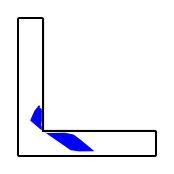

Disconnected Sofa with vertices at:
[(0.16137730916291215, -0.026750904078046325), (0.2042599240809541, -0.02621736188929398), (0.2044050235898474, -0.03602302210255552), (1.0155514366970162, -0.02402006221788873), (1.3869215012998872, -0.10125435652886827), (1.4375986725903245, -0.12555707431337357), (1.7548589828069379, -0.36667097994500203), (2.324336107684821, -0.8408533738913295), (1.6551725069942798, -0.8498752334397259), (1.2754866394173716, -0.7988231884408505), (0.12114949037690903, 0.0), (0.16104447647674822, 0.0), (0.16137730916291215, -0.026750904078046325)]
[(-0.07589809820454996, 0.13636066647951606), (-0.5146224697929936, 0.5117853841442321), (-0.46918504965216234, 0.6334268977904676), (-0.3275504945950801, 0.9508632829636414), (-0.32446399841866713, 0.9550610534766968), (-0.1295659121432635, 1.1935817969624793), (-0.0678053072195259, 1.1517164001169953), (-0.10429821029645828, 1.0991148523575263), (0.0, 1.02675682029257), (0.0, 0.5138670294507515), (-0.02996053835704795

 72%|███████▏  | 7232904/10000000 [2:53:51<1:05:16, 706.57it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 73%|███████▎  | 7302918/10000000 [2:55:29<1:01:32, 730.46it/s]

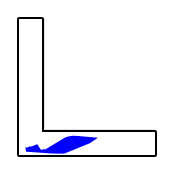

Sofa with vertices at:
[(-0.19939074998620968, -0.5354319179946213), (-0.05657862935465732, -0.7617118336012972), (-0.039079073321604346, -0.7506673328090352), (-0.008573251077268251, -0.7978549693957191), (0.04756186814896999, -0.7615647863594498), (0.048040290496736054, -0.7623288398726931), (0.05755190285664055, -0.7563730163113889), (0.062309816061563605, -0.7641345808144911), (0.10408400284597524, -0.7385266051483659), (0.10569038319554558, -0.7411315459038077), (0.11014166926142684, -0.7383865857922854), (0.13342313049096383, -0.7769866122115698), (1.010025075460034, -0.24826743534233534), (1.0917591083936198, -0.21046468351301542), (1.3470084199185288, -0.15929408361730685), (1.5436546062813, -0.164162853031884), (2.4885701620087244, -0.24900959580658527), (2.109531790487699, -0.49655360315038277), (0.9885400438455368, -0.9513435384067261), (0.5629881765705171, -0.9477439249062356), (0.35302055526663934, -0.9391775499753748), (-0.697314860586371, -0.8638713589826933), (-0.729989

/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 74%|███████▍  | 7407977/10000000 [2:57:59<1:01:59, 696.92it/s]

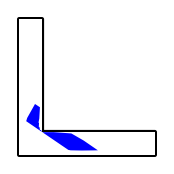

Disconnected Sofa with vertices at:
[(-0.08870036523935895, 0.09679562894563437), (-0.028080200978493425, 0.09584170565967226), (-0.027925262444239263, 0.06754515499521295), (-0.02144378220764477, 0.06758064451687103), (-0.02187865385880819, 0.048262607316224136), (0.0, 0.047770093183965724), (0.0, 0.013896786709674397), (-0.6920861326037292, 0.4861242366413178), (-0.6493747304490471, 0.6289257385858522), (-0.3023588344909023, 1.247853808969202), (-0.08432757189597462, 1.1029313282064865), (-0.11311951849522622, 0.6058528508617337), (-0.1479701095966919, 0.41752725325340395), (-0.12428168889390218, 0.41314359285759633), (-0.13472723677549528, 0.23280646219103224), (-0.10233761128030494, 0.23093037941913536), (-0.10686081586414425, 0.1699700470055983), (-0.0875714096791069, 0.16853878954650478), (-0.08870036523935895, 0.09679562894563437)]
[(0.7045672670805841, -0.012302874189159221), (1.3053038458672823, -0.05631622799191084), (1.8568584015410086, -0.37433175503561417), (2.481196605692

 75%|███████▌  | 7517993/10000000 [3:00:34<58:02, 712.64it/s]

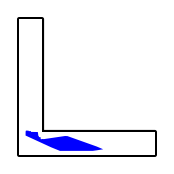

Sofa with vertices at:
[(-0.48108445912329956, 0.04569974644431188), (-0.48181773683253304, 0.011642921089481326), (-0.17491708448838855, 0.005035041318860692), (-0.17583109010083292, -0.023431603317556476), (-0.17162965729850366, -0.023566502713347023), (-0.15619757410454918, -0.16626060833437586), (-0.13492456404176778, -0.16395997468419193), (-0.12772974122972075, -0.22244954721216753), (-0.06195927421799921, -0.21435909901837077), (-0.04987902921732487, -0.29903817260516985), (-0.04814509195652822, -0.29879081058242885), (-0.04552934058592417, -0.3150925230217466), (0.04421710572845925, -0.30069192610117507), (0.04526968960580232, -0.30699264755653666), (0.07247063120301077, -0.3024485214946837), (0.07367944786602497, -0.31066400864136823), (1.0294148720820866, -0.17003827512152078), (1.1352217692046234, -0.17495417864372498), (2.4305005648527915, -0.6362909379413485), (2.716120521643291, -0.7574390655262508), (2.6803981306653717, -0.7638144054443705), (2.43796608994574, -0.8034057

 76%|███████▌  | 7622664/10000000 [3:03:03<56:40, 699.08it/s]

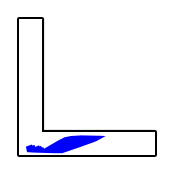

Sofa with vertices at:
[(-0.08841758144219806, -0.6277991794337702), (-0.043677809624674796, -0.6049017932547152), (-0.027073557917519177, -0.6349461709421004), (-0.020583445200242204, -0.6313593612472285), (0.007448121142122925, -0.6865764416604055), (0.052243512303769564, -0.6638355620306968), (0.06386534958413018, -0.6858827862305357), (0.07407732130923081, -0.6804997106730414), (0.10338509564662403, -0.7308599914310548), (0.7110824865364296, -0.3772031466012762), (1.0101899662236997, -0.22455972808741398), (1.2940402374835958, -0.17026852659750824), (1.7373678126937437, -0.1425586188227859), (2.60986421734081, -0.1606371394730837), (2.8260114414661284, -0.17220723783556807), (2.469177442286813, -0.37073265811842715), (2.3936866476311685, -0.4080761779100644), (1.7111970590171917, -0.654616164583581), (0.9024340889006711, -0.9321582720994036), (0.5794721718068997, -0.9327667117883631), (-0.29226875395672686, -0.9063519135594207), (-0.6550356851882916, -0.8868766234880231), (-0.70641

 77%|███████▋  | 7669293/10000000 [3:04:09<54:49, 708.62it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 77%|███████▋  | 7729464/10000000 [3:05:36<55:03, 687.33it/s]

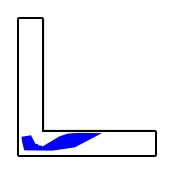

Sofa with vertices at:
[(-0.0672576015771805, -0.6092753666331276), (-0.028082217934813046, -0.5882505163399687), (-0.023932401157096925, -0.5960572184591901), (-0.008647227450608856, -0.5879320627495428), (0.022615558310531747, -0.6400541186761397), (0.7747781705149644, -0.18890732132028132), (1.1276373710756566, -0.06862645924890505), (1.341779301985683, -0.04628634198043158), (1.77870205959705, -0.03040965742818745), (2.662319961802121, -0.041336994138576236), (1.4536901318342212, -0.6753378797673573), (0.4678010003138542, -0.8169776417911521), (-0.7676312698151151, -0.8075671015710739), (-0.7938932741209181, -0.7537325521513296), (-0.871613075452856, -0.4356925195386076), (-0.9017550383303137, -0.2151593265861878), (-0.9015586495668644, -0.20414182435457112), (-0.47907215738999, -0.13787043139504912), (-0.27780711656800017, -0.5335785891950979), (-0.23446843590081862, -0.5115356740776928), (-0.23108288741378358, -0.5182195721101543), (-0.21085037195419107, -0.5079713364592702), (-0

 78%|███████▊  | 7776814/10000000 [3:06:41<50:51, 728.60it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 78%|███████▊  | 7837303/10000000 [3:08:09<53:08, 678.31it/s]

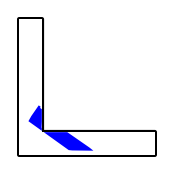

Disconnected Sofa with vertices at:
[(-0.46844801492529364, 0.7101412096519709), (-0.13714518644915014, 1.1873943505726259), (-0.04903594872789943, 1.1226973771531614), (-0.08186353360461457, 1.0762368677477765), (0.0, 1.0183945812100843), (0.0, 0.46176046273843335), (-0.012418965108525526, 0.19340974371809622), (0.0, 0.19283500818196717), (0.0, 0.05933702027526333), (-0.5939782135757601, 0.4850893164362178), (-0.46844801492529364, 0.7101412096519709)]
[(1.1299030498983205, -0.0024538137325078313), (2.107784633832343, -0.6808858086278083), (2.283185322048088, -0.8210125466347925), (1.345280280271804, -0.8093943335493562), (1.191109198980144, -0.7944274189814807), (0.08278263586553936, 0.0), (1.1165343797250733, 0.0), (1.1299030498983205, -0.0024538137325078313)]


 79%|███████▉  | 7889323/10000000 [3:09:26<52:07, 674.90it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 79%|███████▉  | 7944126/10000000 [3:10:46<51:06, 670.34it/s]

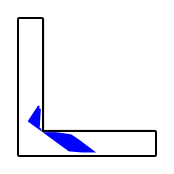

Disconnected Sofa with vertices at:
[(1.2708335284382204, -0.09168242817140021), (1.3437612854293004, -0.12601839730626366), (1.6567726783185237, -0.33622649324785814), (2.4052110872050867, -0.9000562845505186), (1.784873963762175, -0.900028093976826), (1.1945542086233099, -0.850522681605926), (0.029344093313000696, 0.0), (0.6292882680993224, 0.0), (1.2708335284382204, -0.09168242817140021)]
[(-0.628734220485956, 0.4803515905025739), (-0.16300109191829448, 1.187137514714797), (-0.0871836567691599, 1.1332449559603792), (-0.12730962083394246, 1.0765121052669155), (-0.04386203884096147, 1.0174913679795339), (-0.09533505146757479, 0.17580062172664435), (-0.06554719041744572, 0.17397896578617095), (-0.06572173611904611, 0.17091780298856085), (-0.025232481256469316, 0.1686091294992636), (-0.025235596665315312, 0.10005416559715732), (-0.017718271699059457, 0.10005382398016323), (-0.01962337894554407, 0.06721130098555686), (0.0, 0.06607300106152822), (0.0, 0.021419155743615553), (-0.6287342204

 79%|███████▉  | 7948938/10000000 [3:10:52<50:03, 682.97it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 81%|████████  | 8052091/10000000 [3:13:24<48:42, 666.50it/s]

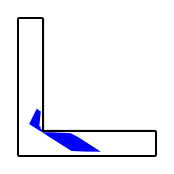

Disconnected Sofa with vertices at:
[(1.6470141459964447, -0.2454633907727741), (2.61219287724539, -0.8634087985788723), (1.9937543261538062, -0.8624202139657275), (1.3086064529630685, -0.8331678397242261), (0.0015867518535116476, 0.0), (0.08046140961937462, 0.0), (0.08048796892358585, -0.0058569427137216), (0.4217266157020563, -0.0043095379547183205), (1.264061462172477, -0.04252833147766197), (1.4919485467925482, -0.1567513279530006), (1.6470141459964447, -0.2454633907727741)]
[(-0.5621428484904161, 0.35935294082287295), (-0.22695112464352846, 1.039250271303424), (-0.1325472382363997, 0.9796055786768826), (-0.13853235014616166, 0.9699993405639316), (-0.04544898640445978, 0.9120042812721793), (-0.11388323884157757, 0.2551940333594436), (-0.04919292142943542, 0.24845383171659718), (-0.059501515955765735, 0.15076859708086826), (-0.00037706815432030083, 0.14452927174934738), (0.0, 0.10893161888868227), (0.0, 0.0010114848405471388), (-0.5621428484904161, 0.35935294082287295)]


 81%|████████  | 8062574/10000000 [3:13:39<47:30, 679.59it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 82%|████████▏ | 8157713/10000000 [3:15:53<43:49, 700.70it/s]

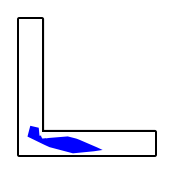

Sofa with vertices at:
[(0.050951830228671016, -0.5301717110816051), (-0.6357927540872227, -0.19571653747895446), (-0.5624789231285012, 0.08789800496894012), (-0.5110627499059679, 0.2820306814937851), (-0.13722703085867582, 0.19553093274434682), (-0.10404851458225614, -0.15773524145653206), (-0.055776784751332305, -0.1532015937686124), (-0.05576150431610028, -0.15353469587633908), (-0.03123772268673606, -0.15240971333150188), (-0.030181959193762563, -0.16356303930417396), (-0.028216108115779313, -0.1633769536642632), (-0.022978185140443412, -0.23102934769458866), (0.003033518422172754, -0.22901541601233208), (0.004838819435102469, -0.24819387434613244), (0.013729230659775174, -0.24735700476517203), (0.019220059428855615, -0.28580086441887625), (0.10623818244221811, -0.27337230970098053), (0.10646040895626865, -0.27491192377258267), (0.18075536867677863, -0.26418825592960865), (0.18239951952845906, -0.27577433061530987), (0.32251388356275196, -0.255891052006389), (1.1465536482277876, -0

 82%|████████▏ | 8162608/10000000 [3:16:00<43:56, 697.00it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 83%|████████▎ | 8266095/10000000 [3:18:28<40:44, 709.33it/s]

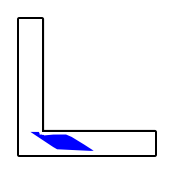

Sofa with vertices at:
[(-0.09939114406239602, -0.10877813517426577), (0.008059238165950798, -0.10463501727780408), (0.009049717704287592, -0.12166379206799127), (0.06966700453326233, -0.11813798454435223), (0.07033312201613598, -0.12726128829286748), (0.09477504939282305, -0.12547671599433052), (0.09665128563139427, -0.1453748369359594), (0.5065474799119842, -0.10672485103941295), (1.0716148192422332, -0.10398362892081406), (1.3187856655042576, -0.21019019069057687), (1.8697507918609713, -0.5467653819862097), (2.2963843177846397, -0.8222754925668709), (2.164290626080808, -0.8292096279801415), (0.6770672459579667, -0.7580906466887494), (0.5010860715280018, -0.6567951192671098), (-0.5062783713337775, 0.012227082511189258), (-0.1284330432243975, 0.009685838092451403), (-0.12664192577630554, -0.02795582987893061), (-0.10255172441070462, -0.026809536892477864), (-0.09939114406239602, -0.10877813517426577)]


 83%|████████▎ | 8309410/10000000 [3:19:29<40:11, 701.06it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 84%|████████▍ | 8375108/10000000 [3:21:03<40:30, 668.64it/s]

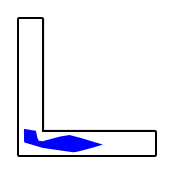

Sofa with vertices at:
[(-0.15403497938811372, -0.34003987043798267), (-0.15338730045280463, -0.33988088598734867), (-0.14292227972433075, -0.38542616092945536), (-0.11384072854390749, -0.3787440399782446), (-0.11007752877094938, -0.39449355266008757), (-0.059101102564933006, -0.382313209090102), (-0.055232381823771826, -0.3975481906831435), (-0.02412933186829673, -0.38964998524447725), (-0.020926015284381802, -0.4016658057258252), (0.010333329807041172, -0.393332327484442), (0.014172411288775562, -0.4070148624884442), (0.08872269280802095, -0.3860973493847021), (0.8212630640365363, -0.19028663984921387), (1.2156695609359318, -0.1280505833410273), (1.2339576929137723, -0.12988205887287357), (1.2734858297860554, -0.13708484792607192), (1.6957634892272777, -0.24939512000908617), (2.7072953254983694, -0.5520899152348352), (1.984618071257752, -0.7588721922344847), (1.5715552446942656, -0.8641892816235478), (1.405218711320673, -0.8917226818309726), (0.05265703086486335, -0.70032432230115), 

 84%|████████▍ | 8418757/10000000 [3:22:05<37:24, 704.57it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 85%|████████▍ | 8480935/10000000 [3:23:31<35:04, 721.80it/s]

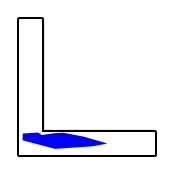

Sofa with vertices at:
[(-0.06632359435741567, -0.06128768858974373), (-0.06614344534447593, -0.0628236356064929), (-0.05757435800401032, -0.061818579696786086), (-0.051100702335434296, -0.11322427045404068), (-0.011851172263794521, -0.1082814725051332), (-0.00898592886113396, -0.1278701473564305), (0.005117357504542078, -0.12580725394879405), (0.005259344788214118, -0.12654960478614008), (0.02221880281919393, -0.12330581861762518), (0.5241186281051606, -0.04989272793569646), (0.6416749737186208, -0.04098440803812306), (0.8770733097792335, -0.026672402519594768), (0.978368278342087, -0.02943039906818798), (1.8627759162159045, -0.20029879891466199), (2.90507920377171, -0.502064708186159), (2.246704036600071, -0.6251631328953541), (0.5920277987532983, -0.7387849995370485), (-0.6491894692860608, -0.4149562024541803), (-0.8535099209430186, -0.35649002311765055), (-0.8460443978623994, -0.08144503496686162), (-0.8445103087551656, -0.05985488104619205), (-0.17796863561326406, -0.0153819303532

 85%|████████▌ | 8533935/10000000 [3:24:45<33:27, 730.20it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 86%|████████▌ | 8587847/10000000 [3:26:01<33:07, 710.52it/s]

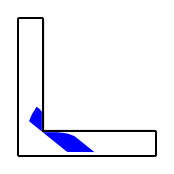

Disconnected Sofa with vertices at:
[(0.1852384081094948, -0.002042273582033613), (0.2951882710895839, -0.0019541158084280946), (0.2951926876035903, -0.002944320886865248), (0.5658596990460586, -0.0017370915228081818), (0.681727985464159, -0.0016441883587182682), (0.93219315478254, -0.0298573491122478), (1.1646384621977566, -0.06961406621818256), (1.4447139763919208, -0.17372258152634676), (2.3282371178337917, -0.8829039901003742), (1.1923684161402097, -0.8769164646545925), (1.1420648982581938, -0.8719159646016658), (1.1299829395060614, -0.8697713885187782), (1.1009251148900272, -0.8602687451625047), (0.034769060425356546, 0.0), (0.18523677061502955, 0.0), (0.1852384081094948, -0.002042273582033613)]
[(-0.5671969713590199, 0.4857192909283976), (-0.437123364738849, 0.7966476885006247), (-0.23011476186162355, 1.1274703797089225), (-0.2122380804505145, 1.113628073426816), (-0.21223808045051507, 1.1136280734268165), (-0.057250503255233044, 0.993617795001993), (-0.07273520848596512, 0.97298

 86%|████████▋ | 8627325/10000000 [3:26:56<32:08, 711.64it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 87%|████████▋ | 8696388/10000000 [3:28:31<30:12, 719.05it/s]

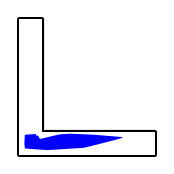

Sofa with vertices at:
[(1.8636094582223444, -0.6937042014282385), (0.24762786859223612, -0.7951499584001912), (-0.7487439075576797, -0.7228373451561229), (-0.7731663447705702, -0.5233254044839079), (-0.7550394751249602, -0.11419877589993732), (-0.25902855471532904, -0.08207038680313822), (-0.2483506316306714, -0.1584850510759037), (-0.16935152843485585, -0.1474459873607126), (-0.16706844918597213, -0.16278776011943072), (-0.16447367315278685, -0.16240161965117852), (-0.16039955380000953, -0.18078438836431213), (-0.16033374490522467, -0.180769803331122), (-0.15992801167081758, -0.1837022387309655), (-0.1409456964895446, -0.18107583607076386), (-0.12219926640310941, -0.2679960388902296), (-0.09263323789761922, -0.2616194144883869), (-0.08751548810895876, -0.2860250351306328), (-0.05792248578189467, -0.2798195145407151), (-0.05712696601111038, -0.2828548659765161), (-0.05513993503828464, -0.2823340951671146), (-0.05039234512115958, -0.30098069791654014), (0.4559213633576072, -0.172068751

 87%|████████▋ | 8723854/10000000 [3:29:10<29:49, 713.07it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 88%|████████▊ | 8804434/10000000 [3:31:02<27:28, 725.24it/s]

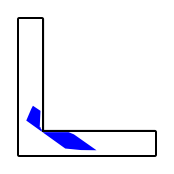

Disconnected Sofa with vertices at:
[(-0.3946316717411219, 1.1695247383684464), (-0.09035983174977194, 0.9655171005932585), (-0.06046048541376084, 0.9444806783444922), (-0.09400363997941213, 0.22213115434123903), (-0.0558644123925173, 0.22036011419592005), (-0.05600238476646724, 0.1764804272195878), (-0.04399349224614274, 0.1764426672553832), (-0.04626711694834809, 0.14118334196436474), (-0.01854829341300937, 0.13939595092991192), (-0.01932026693272225, 0.12604136204276484), (-0.007386785534598525, 0.12535153686617667), (-0.008554596863616426, 0.09082986827945097), (0.0, 0.0905404803227995), (0.0, 0.07857974022354763), (-0.0001944420323060081, 0.07315518503146586), (0.0, 0.07314821529798753), (0.0, 0.019113263831256277), (-0.6895248715373375, 0.5134434359930901), (-0.4707398178725619, 1.0264169266557326), (-0.3946316717411219, 1.1695247383684464)]
[(1.4214625722819265, -0.09816282400938482), (2.4209683900039276, -0.801389783736434), (1.733504311912709, -0.7926878302928461), (1.03739495

 88%|████████▊ | 8820471/10000000 [3:31:25<27:01, 727.48it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 89%|████████▉ | 8909451/10000000 [3:33:28<25:16, 719.15it/s]

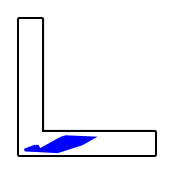

Sofa with vertices at:
[(-0.31504202368013046, -0.5584125935929648), (-0.3040707768071028, -0.5872994017689438), (-0.2017155387555489, -0.5484247508012788), (-0.19093322686901879, -0.5738279643005314), (-0.1531990816301825, -0.5578118282810179), (-0.0713965340841971, -0.7046438808723733), (0.6836886958933271, -0.2839735004179602), (0.8840967384247745, -0.18684102349564755), (1.0576072436996549, -0.1384518664217101), (2.4695673178923783, -0.19951762644504387), (1.791153333719274, -0.5805684162959083), (0.7044317257319185, -0.9289029458237866), (-0.7586441788625051, -0.8529000644593548), (-0.7905465638641894, -0.73735664240264), (-0.31504202368013046, -0.5584125935929648)]


 89%|████████▉ | 8920871/10000000 [3:33:44<24:40, 728.66it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 90%|█████████ | 9015401/10000000 [3:35:56<23:19, 703.39it/s]

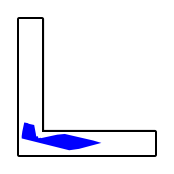

Sofa with vertices at:
[(-0.3394209975624114, 0.3176017559640524), (-0.26556763586388915, -0.07725157215005052), (-0.24953688279714875, -0.18948235512173742), (-0.17712466972440172, -0.17913918298973777), (-0.16280110687992674, -0.2372505345189437), (-0.1576829180584291, -0.2359889789483817), (-0.14906574831155947, -0.27024992989912056), (-0.05070510023946362, -0.24551067493599957), (-0.04604223362061734, -0.2672265263762069), (0.6784310138609151, -0.11166632965861234), (1.0153761603138935, -0.07919919734056888), (2.2687792942506797, -0.36802933825137096), (2.6362925525958647, -0.4758138154522368), (1.6464925045677956, -0.7395588930204496), (1.2123072995368733, -0.8014677087006324), (-0.8911036615891266, -0.2772894443089279), (-0.8924472181295816, -0.17597743546466024), (-0.8620528494038513, 0.04168173076252193), (-0.7786223711009465, 0.42993542251101224), (-0.5950472307571342, 0.3931055439404044), (-0.5990785745853675, 0.3748070951255015), (-0.3394209975624114, 0.3176017559640524)]


/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 91%|█████████ | 9122737/10000000 [3:38:26<20:11, 724.03it/s]

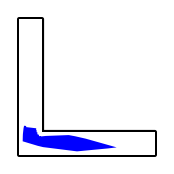

Sofa with vertices at:
[(-0.03868380215698867, -0.16871658191391642), (-0.03843382198115491, -0.17536160443055662), (-0.035067396749123715, -0.17523496233576716), (-0.0337543225659608, -0.18825683800341886), (0.17301443609187173, -0.16740709824183483), (1.1756788952358883, -0.12968770193109241), (1.2105450783891536, -0.13265986424737802), (1.4717818845709232, -0.1812588594888868), (1.9352083390927552, -0.28605103541603594), (3.3124892264580823, -0.6738491890528383), (2.9339615193064086, -0.7195543095236512), (1.5576010420706754, -0.8507129308918141), (0.05436076009053095, -0.6622339310808177), (-0.1884277510543153, -0.6030751952548471), (-0.8482976583557038, -0.40478435002723395), (-0.8427478723087809, -0.1710846265228799), (-0.8384136724626767, -0.08068964059306565), (-0.8086239963140875, 0.18355679230876948), (-0.7861624966901067, 0.2843574775163511), (-0.6920714923633994, 0.2733905467113828), (-0.6978350657076858, 0.22455692835914667), (-0.2496167920076862, 0.17165609934242482), (-0

 92%|█████████▏| 9165138/10000000 [3:39:26<19:42, 705.78it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 92%|█████████▏| 9231269/10000000 [3:40:59<17:58, 712.59it/s]

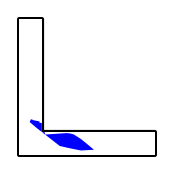

Disconnected Sofa with vertices at:
[(0.14489151671479586, -0.1053178225452929), (1.0906226079161694, -0.04127766680220149), (1.2617857166785413, -0.05800022287000614), (1.4119310242783283, -0.10128817753597538), (1.6254781022810851, -0.23522658863703025), (1.7193630370615114, -0.2969135945288841), (1.8024253800271242, -0.36046988691606685), (2.020686623882886, -0.5379456850913386), (2.3074488681111514, -0.7797696009814626), (1.7221370308474413, -0.8107733291759439), (1.17750730696239, -0.7000852444758644), (1.1714363140281585, -0.6988211423116107), (0.7937059410587745, -0.6122452064061868), (0.008190909555578996, 0.0), (0.09909613665734872, 0.0), (0.09956289326502646, -0.006996456734685505), (0.13805977880889148, -0.004428203062289998), (0.14489151671479586, -0.1053178225452929)]
[(-0.2264423142375394, 0.18287755264984057), (-0.5387627913702551, 0.4471685889979323), (-0.5184008051816607, 0.49968334533186765), (-0.48469839288774563, 0.5702696657870607), (-0.40419502625613885, 0.5532913

 93%|█████████▎| 9307830/10000000 [3:42:46<16:00, 720.89it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 93%|█████████▎| 9341533/10000000 [3:43:33<15:18, 716.85it/s]

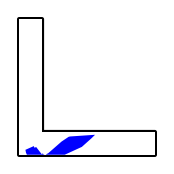

Disconnected Sofa with vertices at:
[(2.196470091652101, -0.2724796774402183), (1.771149733051685, -0.6526381016222716), (1.0124460909952488, -1.0), (0.17876803183575557, -1.0), (0.24659980970842643, -0.9417524760131252), (0.2575587673715628, -0.9542942007079696), (0.873353244354882, -0.41621305424271815), (1.1856495709222927, -0.20721330406954647), (1.1927108335377485, -0.2035265635760683), (1.255768426672733, -0.19037320328131668), (2.3378696110830735, -0.11734237308459049), (2.356219877605875, -0.11648260735746864), (2.196470091652101, -0.2724796774402183)]
[(-0.7020170851640238, -0.909604626784022), (-0.7265595552171078, -0.7817331382706344), (-0.35635761026385815, -0.617505159747488), (-0.32637520263185593, -0.6899569356147457), (-0.25077188334574263, -0.6586703382879707), (-0.005133142341663503, -0.9766115666769745), (0.03994093920689139, -0.941787707249861), (0.09076673720574199, -0.9957478164348502), (0.09949466155885336, -0.987526859753688), (0.11166103963897854, -1.0), (-0.66

 94%|█████████▎| 9362682/10000000 [3:44:04<15:13, 697.45it/s]/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
 94%|█████████▍| 9379653/10000000 [3:44:27<14:20, 721.05it/s]

In [ ]:
load_previous = False

ModelConfig = namedtuple("ModelConfig", [
  "timesteps_per_batch",
  "max_timesteps_per_episode",
  "n_updates_per_iteration",
  "sample_std",
  "gamma",
  "loss_clip",
  "adam_lr",
  "checkpoint_period",
])

config = ModelConfig(
  timesteps_per_batch=4800,
  max_timesteps_per_episode=1600,
  n_updates_per_iteration=5,
  sample_std=0.5,
  gamma=0.99,
  loss_clip=0.2,
  adam_lr=0.005,
  checkpoint_period=20,
)

# Create Sofa Env
hallway = Polygon([
  [0, 0],
  [0, 5],
  [-1, 5],
  [-1, -1],
  [5, -1],
  [5, 0],
])
start_zone =  Polygon([(0, 0), (5,0), (5, -1), (0, -1)])
end_zone =  Polygon([(0, 0), (0,5), (-1, 5), (-1, 0)])
env = SofaEnv(hallway, start_zone, end_zone)

logger = lambda sofa: print(sofa)

if load_previous:
  pass
else:
  model = PPO(env, config, logger)

model.learn(time_limit=10_000_000)



In [ ]:
config = {
  "timesteps_per_batch": 4800,
  "max_timesteps_per_episode": 1600,
  "n_updates_per_iteration": 5,
  "sample_std": 0.5,
  "gamma": 0.99,
  "loss_clip": 0.2,
  "adam_lr": 0.005,
  "checkpoint_period": 20
}

In [ ]:
torch.tensor([(1, 2), (2, 3)])

In [ ]:
p = Point((0, 1))
list(p.coords)[0]